In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import relativedelta
import xgboost as xgb
from typing import Tuple
import re
#from xgboost import XGBClassifier
from plotnine import ggplot, geom_histogram, aes, geom_col, coord_flip, geom_bar,scale_x_discrete, geom_point, theme,element_text, geom_boxplot, coord_cartesian, scale_color_manual, labs, geom_line, facet_wrap, geom_hline, geom_vline, annotate

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
data_path = Path("../data")

In [4]:
df = pd.read_parquet(data_path / "full_data.parquet")

In [5]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df = df[column_order]
df['churn'] = df['churn'].astype(int)

In [6]:
df = df.drop(['monthly_distinct_ads', 'monthly_avg_ad_price', 'monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta' ], axis=1)

delete  columns with a lot of importance

In [7]:
#df = df.drop(['months_since_last_contract'], axis=1)       # para eliminar la columna de months_since_last_contract

df = df.drop(['months_since_last_contract', 'tenure'], axis=1)   # para eliminar la columna de months_since_last_contract y tenure
#df = df.drop(['months_since_last_contract', 'tenure', 'has_renewed'], axis=1)    # para eliminar la columna de months_since_last_contract , tenure y has_renewed

eliminar el id

In [8]:

df = df.drop('advertiser_zrive_id', axis=1) 

La celda a continuacion hay que comentarla cuando no usemos la columna months_since_last_contract

In [9]:
'''
ids_with_nan_months_since_last_contract = df[
    df['months_since_last_contract'].isna()]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan_months_since_last_contract)]
'''

"\nids_with_nan_months_since_last_contract = df[\n    df['months_since_last_contract'].isna()]['advertiser_zrive_id'].unique()\n\ndf = df[~df['advertiser_zrive_id'].isin(ids_with_nan_months_since_last_contract)]\n"

La celda a continuacion hay que comentarla cuando no usemos la columna tenure

In [10]:
'''
ids_with_nan_tenure = df[
    df['tenure'].isna()]['advertiser_zrive_id'].unique()

df = df[~df['advertiser_zrive_id'].isin(ids_with_nan_tenure)]
'''

"\nids_with_nan_tenure = df[\n    df['tenure'].isna()]['advertiser_zrive_id'].unique()\n\ndf = df[~df['advertiser_zrive_id'].isin(ids_with_nan_tenure)]\n"

In [11]:
def split_train_test_by_period(data_set, execution_date):
    train_end_date = execution_date + relativedelta(months=6)
    val_date = execution_date + relativedelta(months=7)

    train_start_str = execution_date.strftime('%Y%m')
    train_end_str = train_end_date.strftime('%Y%m')
    val_str = val_date.strftime('%Y%m')

    train_set = data_set[
        (data_set['month_period'] >= train_start_str) &
        (data_set['month_period'] <= train_end_str)
    ]
    test_set = data_set[data_set['month_period'] == val_str]

    return train_set, test_set

In [12]:
all_results = {}
all_predicted_clients_list = []
all_models = {}

In [13]:
import warnings
warnings.filterwarnings('ignore')


def train_model(X_train, X_test, n_estimators=300):
    y_train = X_train["churn"]
    y_test = X_test["churn"]

    X_train["month_period"] = X_train["month_period"].astype("category").cat.codes
    X_test["month_period"] = X_test["month_period"].astype("category").cat.codes

    dtrain = xgb.DMatrix(X_train.drop(columns="churn"), label=y_train)
    dtest = xgb.DMatrix(X_test.drop(columns="churn"), label=y_test)

    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",
        "learning_rate": 0.01,
        "max_depth": 3,
        "min_child_weight": 10,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_alpha": 1.0,
        "reg_lambda": 1.0,
        "nthread": 10,
        "random_state": 1
    }

    evals_result = {}

    model = xgb.train(
        params=params,
        dtrain=dtrain,
        num_boost_round=n_estimators,
        evals=[(dtest, "eval"), (dtrain, "train")],
        early_stopping_rounds=20,
        verbose_eval=False,
        evals_result=evals_result
    )


    importance_dict = model.get_score(importance_type='gain')
    importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['importance'])
    importance_df.index.name = 'feature'
    importance_df.reset_index(inplace=True)


    return model, evals_result, importance_df

In [14]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_clients_list, all_models, n_estimators):
        global train_set
        global test_set
        # split the dataset between train and test
        train_set, test_set = split_train_test_by_period(df, execution_date)
        train_size, _ = train_set.shape
        test_size, _ = test_set.shape
        model = None

        # if both train and test are not empty
        if train_size > 0 and test_size>0:
            model, evals_result, importance_df = train_model(train_set, test_set, n_estimators = n_estimators)

            importance_df["execution_date"] = execution_date

            
            test_set['prob'] = model.predict(xgb.DMatrix(test_set.drop(columns="churn")))
            predicted_clients = test_set.sort_values('prob', ascending = False)
            predicted_clients["execution_date"] = execution_date
            all_results[(execution_date)] = evals_result
            all_models[(execution_date)] = model
            all_predicted_clients_list.append(predicted_clients)

        return all_results, all_models, importance_df, all_predicted_clients_list

para incluir predicciones en train y validation

In [15]:
def run_model_for_execution_date(execution_date, all_results, all_predicted_clients_list, all_models, n_estimators):
    global train_set
    global test_set
    train_set, test_set = split_train_test_by_period(df, execution_date)
    train_size, _ = train_set.shape
    test_size, _ = test_set.shape
    model = None

    if train_size > 0 and test_size>0:
        model, evals_result, importance_df = train_model(train_set, test_set, n_estimators=n_estimators)
        importance_df["execution_date"] = execution_date

        # Generar predicciones para train y test
        test_set['prob'] = model.predict(xgb.DMatrix(test_set.drop(columns="churn")))
        train_set['prob'] = model.predict(xgb.DMatrix(train_set.drop(columns="churn")))

        # Guardar ambos conjuntos con identificador
        predicted_clients_test = test_set.copy()
        predicted_clients_test["execution_date"] = execution_date
        predicted_clients_test["dataset_type"] = "val"
        
        predicted_clients_train = train_set.copy()
        predicted_clients_train["execution_date"] = execution_date
        predicted_clients_train["dataset_type"] = "train"
        
        all_results[execution_date] = evals_result
        all_models[execution_date] = model
        all_predicted_clients_list.extend([predicted_clients_test, predicted_clients_train])

    return all_results, all_models, importance_df, all_predicted_clients_list

In [16]:
def train_model_across_periods(n_estimators):
    global all_results
    global all_models
    global all_predicted_clients_list
    global final_importance_df

    feature_importance_list = []

    start_date = datetime.datetime(2023, 3, 1)
    end_date = datetime.datetime(2024, 11, 1)
    current_date = start_date

    while current_date + relativedelta(months=7) <= end_date:
        print(current_date)
        all_results, all_models, importance_df, all_predicted_clients_list = run_model_for_execution_date(
            current_date, all_results, all_predicted_clients_list ,all_models, n_estimators
        )

        feature_importance_list.append(importance_df)

        current_date += relativedelta(months=1)
    
    final_importance_df = pd.concat(feature_importance_list, ignore_index=True)

#train_model_across_periods(n_estimators=params["n_estimators"])

In [17]:
def return_learning_curve(set_name):
    learning_curves = pd.DataFrame()
    for date in all_results:
        learning_curve = pd.DataFrame(all_results[date][set_name])
        learning_curve["n_trees"] = list(range(len(learning_curve)))
        learning_curve["execution_date"] = date
        learning_curves = pd.concat([learning_curves, learning_curve])

    for column in learning_curves.columns:
        if column not in ["n_trees", "execution_date"]:
            first_metric = learning_curves[[column, "execution_date"]].drop_duplicates(['execution_date'])
            first_metric = first_metric.rename(columns={column: "first_" + column})
            learning_curves = pd.merge(learning_curves, first_metric, on=["execution_date"])
            learning_curves["norm_" + column] = (learning_curves[column] - learning_curves["first_" + column]) / learning_curves["first_" + column]
            learning_curves = learning_curves.drop(columns="first_" + column)
    learning_curves["execution_date"] = learning_curves["execution_date"].astype(str)

    return learning_curves

In [18]:
train_model_across_periods(n_estimators=240)

2023-03-01 00:00:00
2023-04-01 00:00:00
2023-05-01 00:00:00
2023-06-01 00:00:00
2023-07-01 00:00:00
2023-08-01 00:00:00
2023-09-01 00:00:00
2023-10-01 00:00:00
2023-11-01 00:00:00
2023-12-01 00:00:00
2024-01-01 00:00:00
2024-02-01 00:00:00
2024-03-01 00:00:00
2024-04-01 00:00:00


# Ver la probabilidad de churn 

In [19]:
all_predicted_clients = pd.concat(all_predicted_clients_list)
#all_predicted_clients[['advertiser_zrive_id', 'period_int', 'churn', 'prob', 'execution_date']]
all_predicted_clients[['period_int', 'churn', 'prob', 'execution_date']]

,period_int,churn,prob,execution_date
24156,202310,0,0.110204,2023-03-01
24157,202310,0,0.054446,2023-03-01
24158,202310,0,0.055224,2023-03-01
24159,202310,0,0.045184,2023-03-01
24160,202310,0,0.102029,2023-03-01
...,...,...,...,...
43954,202406,0,0.035181,2024-04-01
46112,202407,0,0.035288,2024-04-01
48233,202408,0,0.036071,2024-04-01
50262,202409,0,0.035219,2024-04-01


In [20]:
test_lc = return_learning_curve("eval")
train_lc = return_learning_curve("train")

In [21]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(train_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

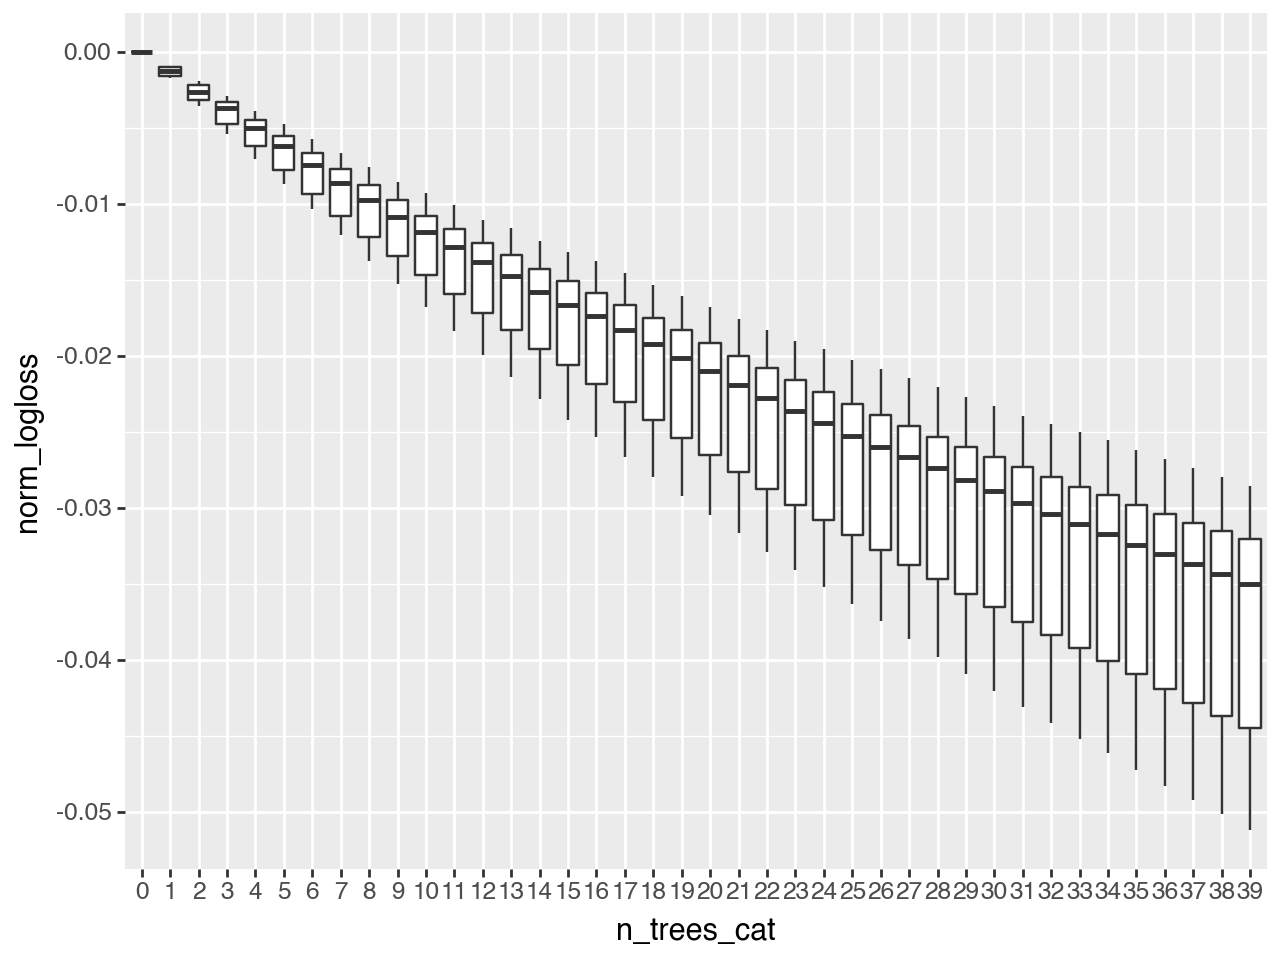

In [22]:
ggplot(train_lc[train_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

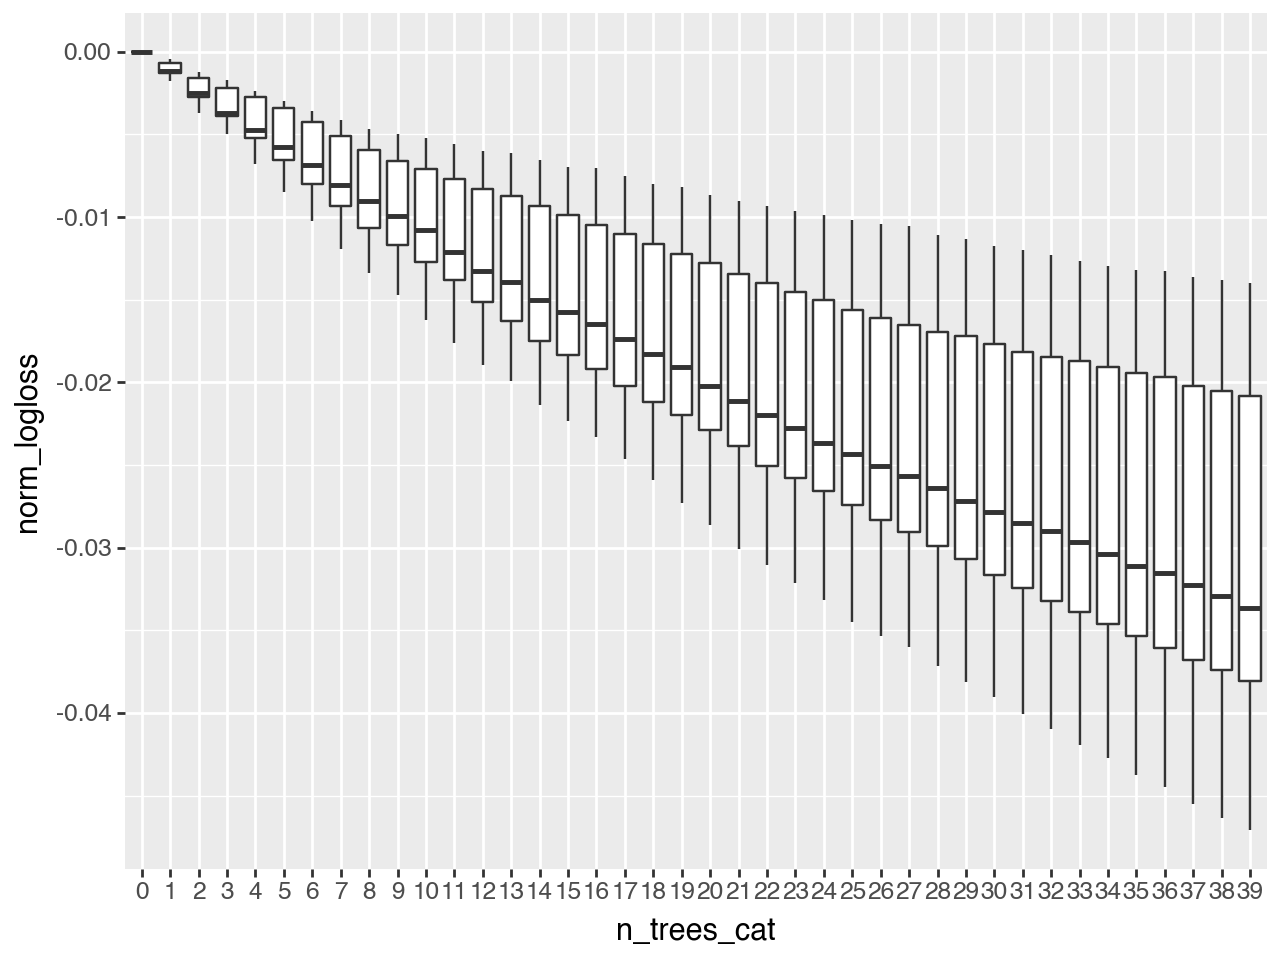

In [23]:
ggplot(test_lc[test_lc["n_trees"] < 40], aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

In [24]:
train_lc['n_trees_cat'] = pd.Categorical(train_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))
test_lc['n_trees_cat'] = pd.Categorical(test_lc['n_trees'], categories=sorted(test_lc['n_trees'].unique()))

filtered_train_lc = train_lc[train_lc["n_trees"] % 10 == 0].copy()
filtered_test_lc = test_lc[test_lc["n_trees"] % 10 == 0].copy()

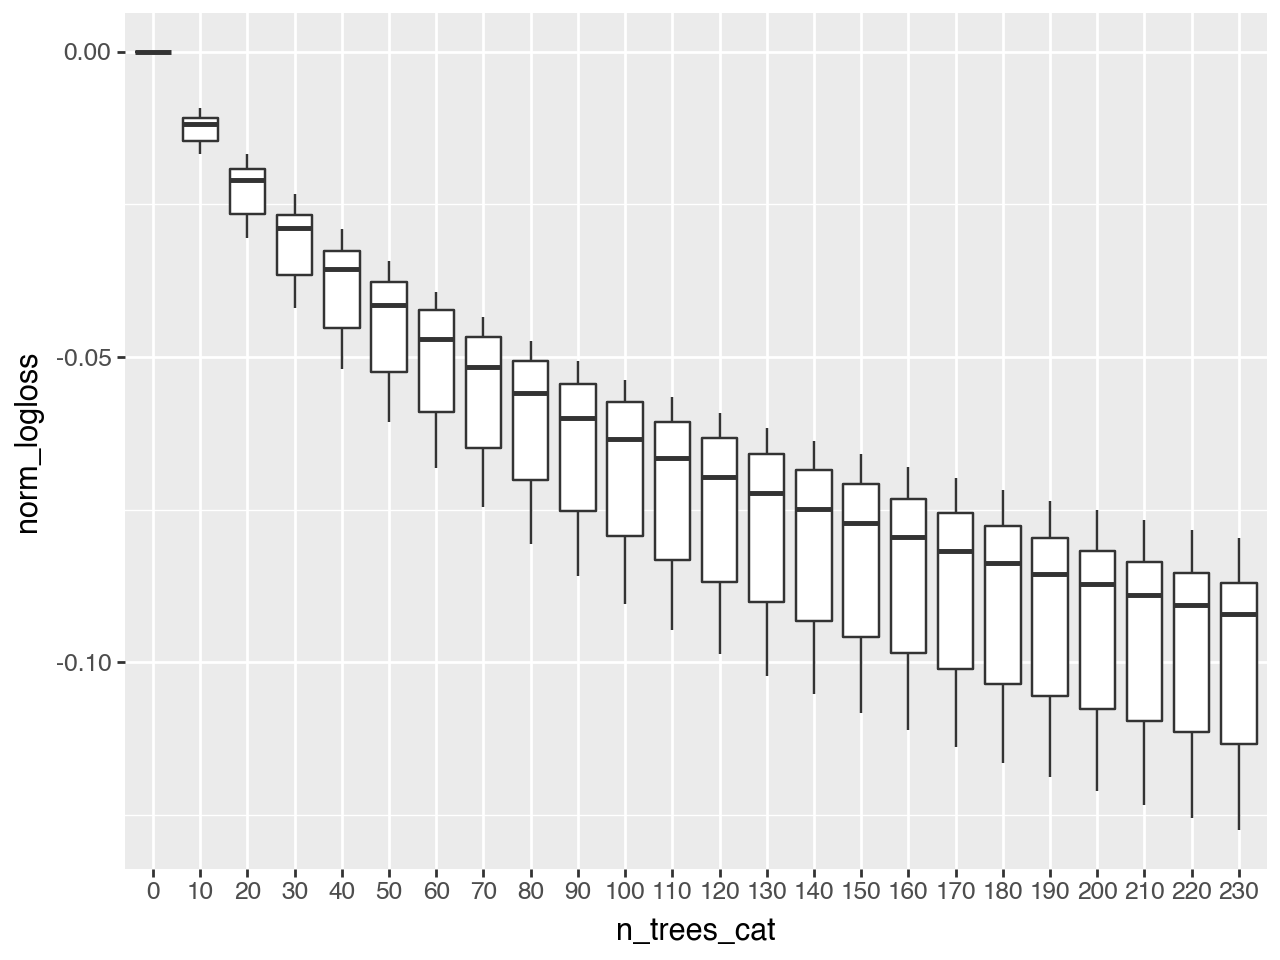

In [25]:
ggplot(filtered_train_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

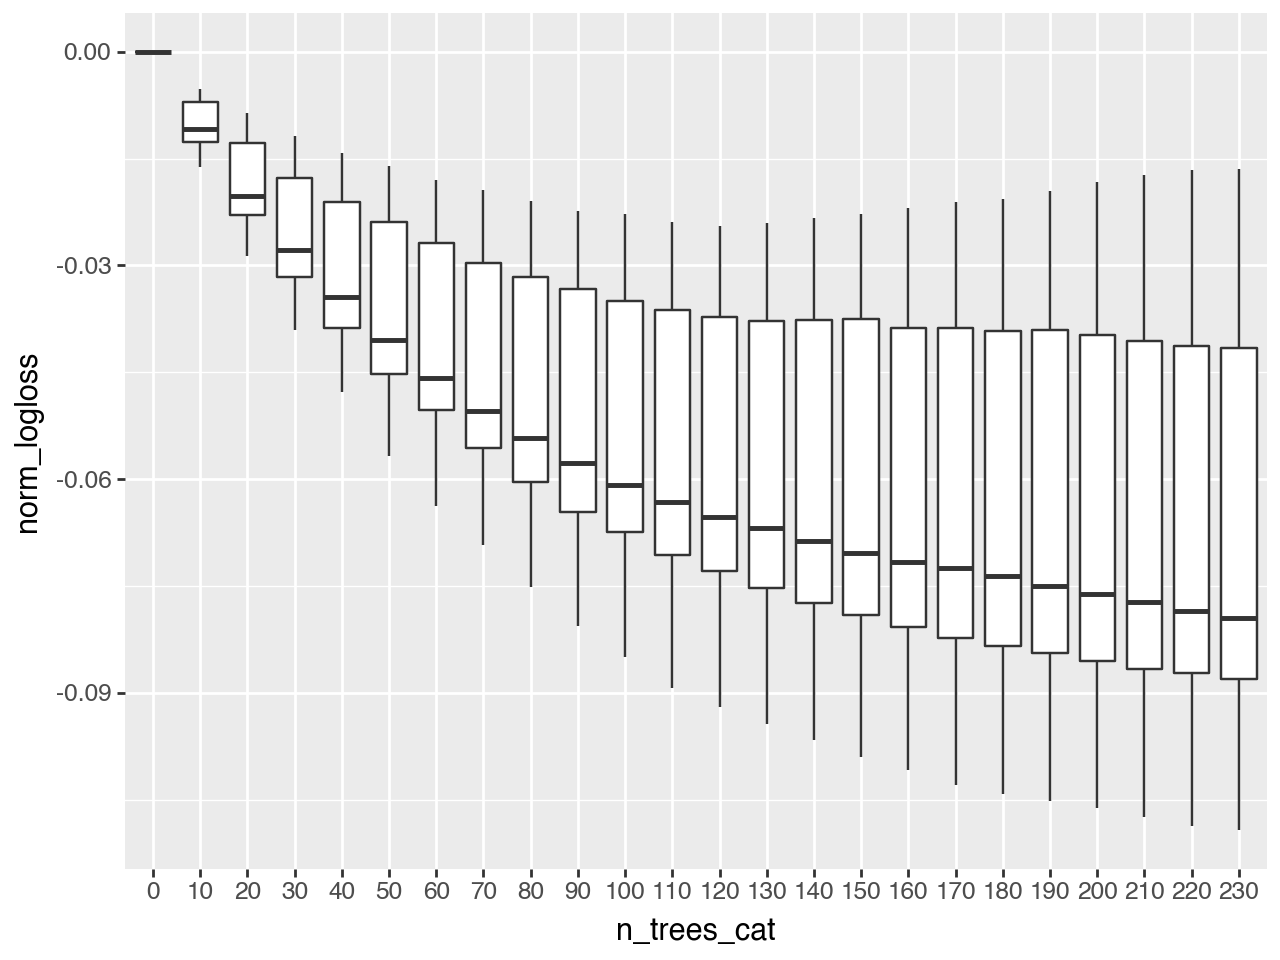

In [26]:
ggplot(filtered_test_lc, aes(x="n_trees_cat", y="norm_logloss")) + geom_boxplot()

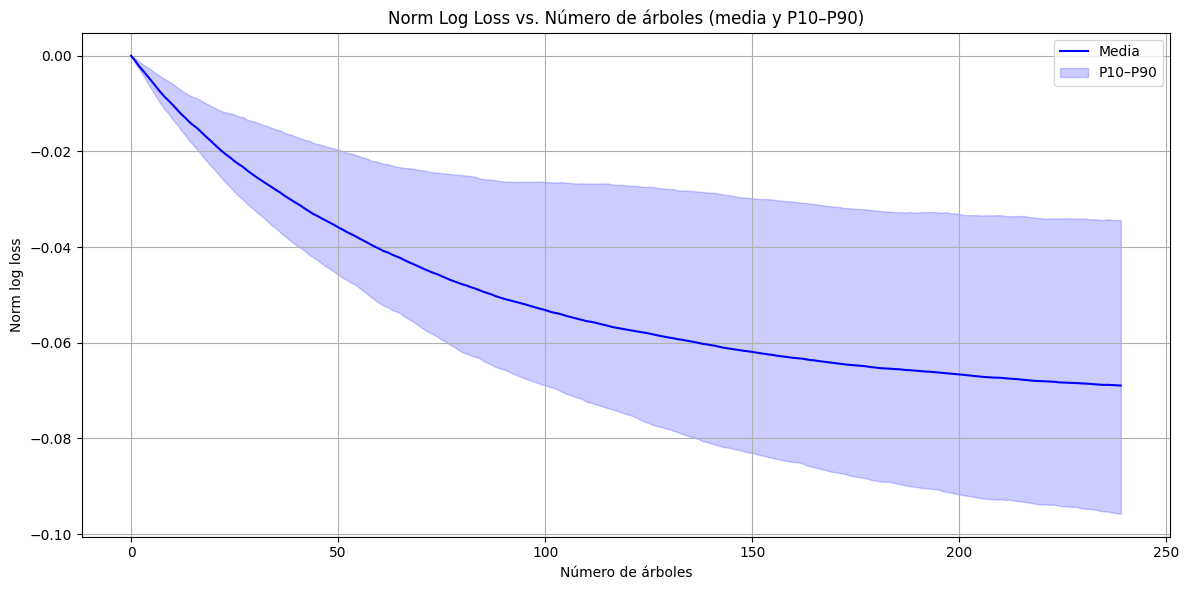

In [27]:
summary = test_lc.groupby("n_trees")["norm_logloss"].agg(
    mean="mean",
    p10=lambda x: x.quantile(0.10),
    p90=lambda x: x.quantile(0.90)
).reset_index()

# Gráfico
plt.figure(figsize=(12, 6))
plt.plot(summary["n_trees"], summary["mean"], label="Media", color="blue")
plt.fill_between(summary["n_trees"], summary["p10"], summary["p90"], color="blue", alpha=0.2, label="P10–P90")
plt.xlabel("Número de árboles")
plt.ylabel("Norm log loss")
plt.title("Norm Log Loss vs. Número de árboles (media y P10–P90)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
train_lc["set"] = "train"
test_lc["set"] = "test"

data_lc = pd.concat([train_lc, test_lc])

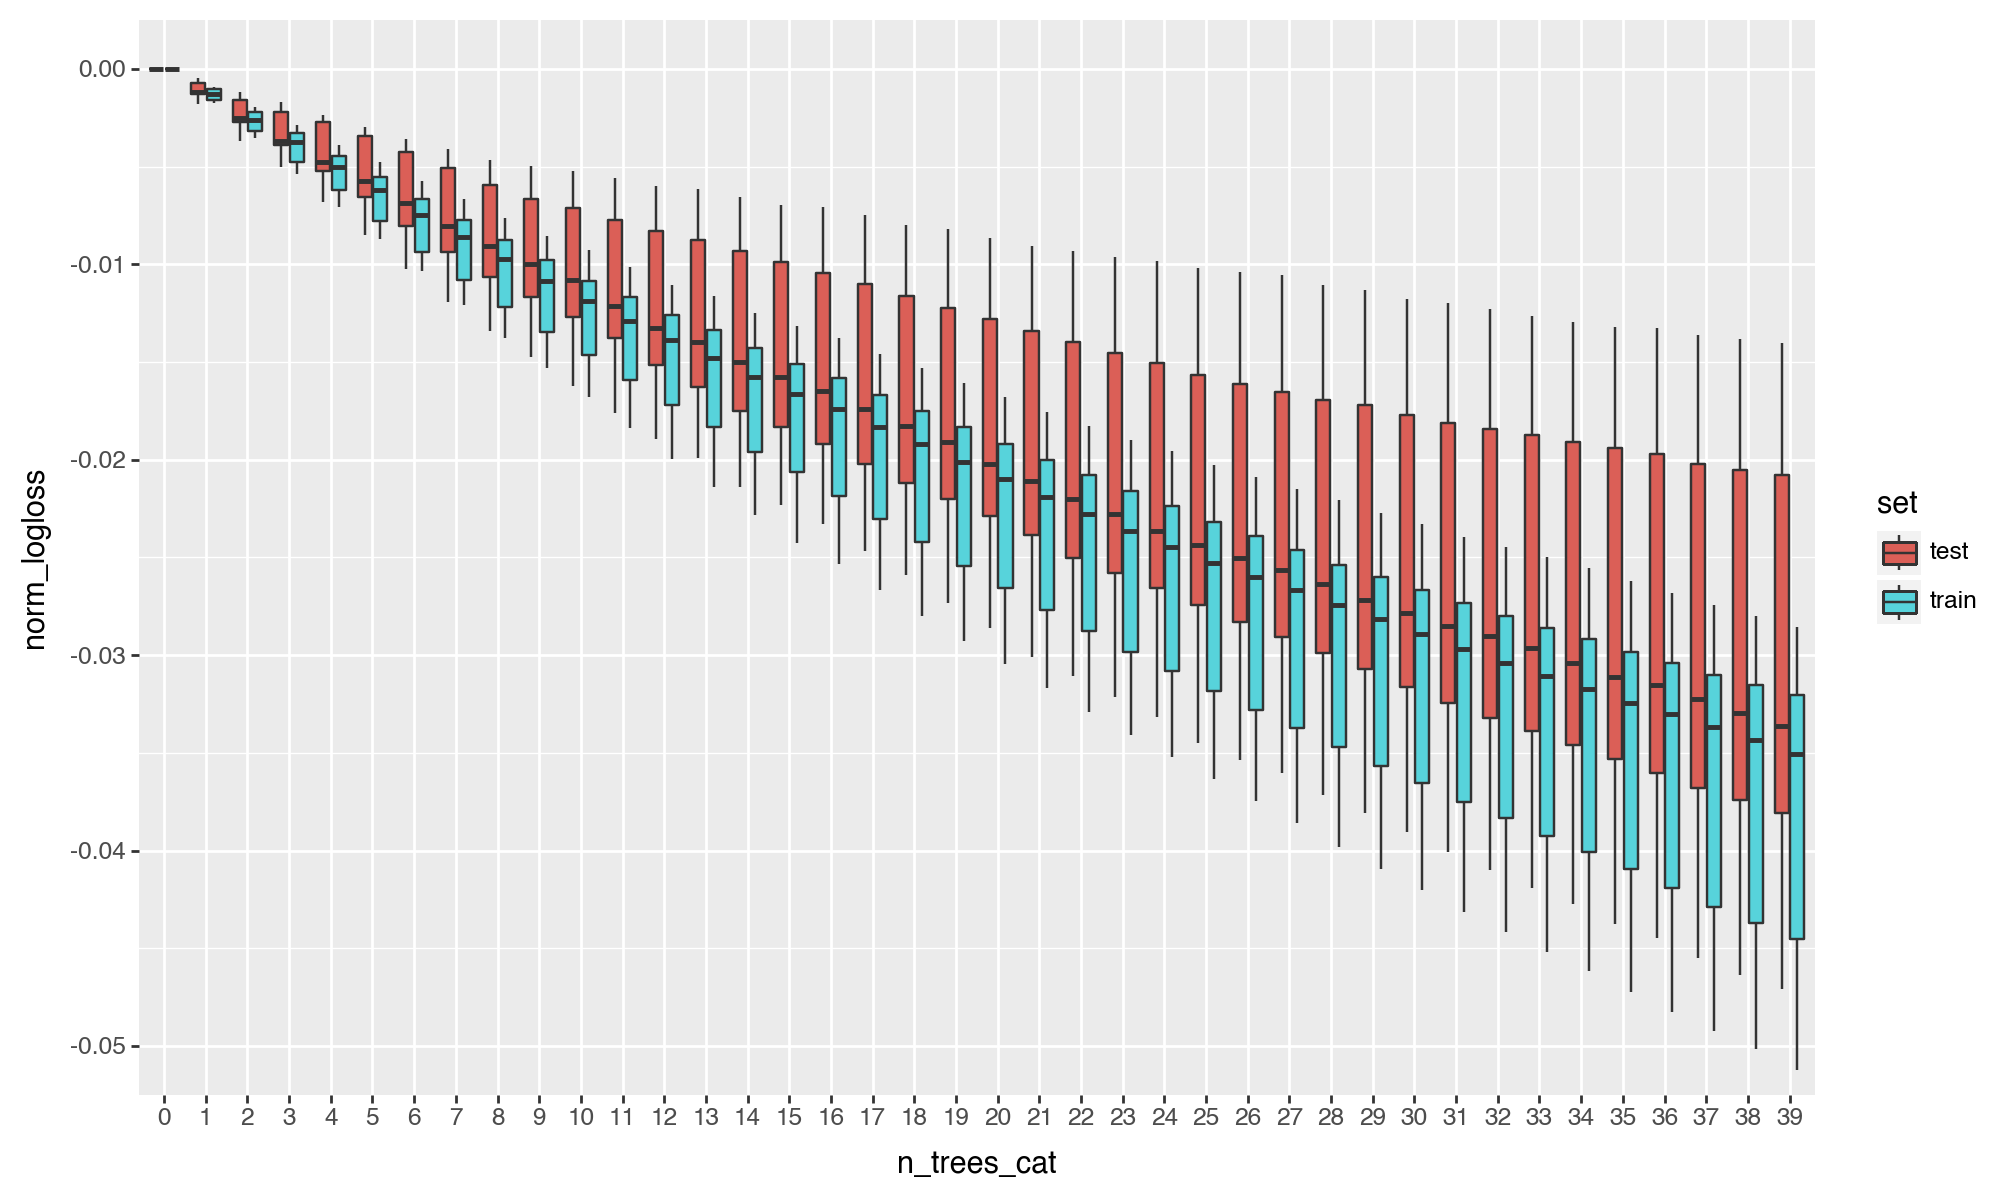

In [29]:
fig = plt.figure(figsize=(10, 6))

ggplot(
    data_lc[data_lc["n_trees"] < 40],
    aes(x="n_trees_cat", y="norm_logloss", fill="set")
) + geom_boxplot(outlier_alpha=None) + coord_cartesian(ylim=(-0.05, 0)) + theme(
    figure_size=(10, 6)
)

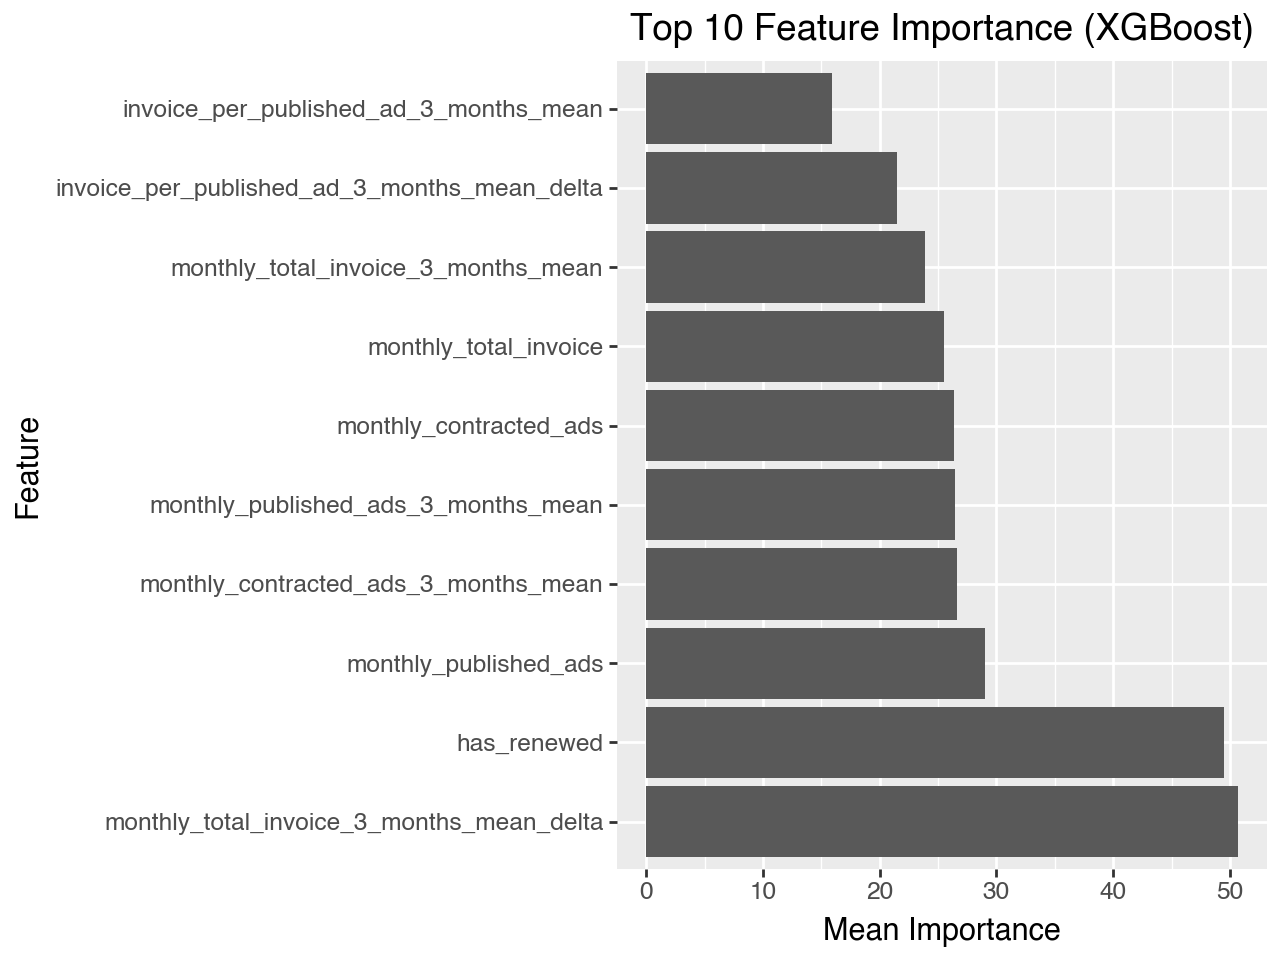

In [30]:
final_importance_df = final_importance_df.sort_values(["execution_date", "importance"], ascending=[False, False])

importance_summary = (
    final_importance_df
    .groupby("feature")["importance"]
    .mean()
    .reset_index()
)

top_features = (
    importance_summary
    .sort_values("importance", ascending=False)
    .head(10)
)

(
    ggplot(top_features) +
    geom_col(aes(x="feature", y="importance")) +
    coord_flip() +
    scale_x_discrete(limits=top_features["feature"].tolist()) +
    labs(title="Top 10 Feature Importance (XGBoost)", x="Feature", y="Mean Importance")
)


Curvas ROC y PR AUC en cada periodo

<Figure size 1000x600 with 0 Axes>

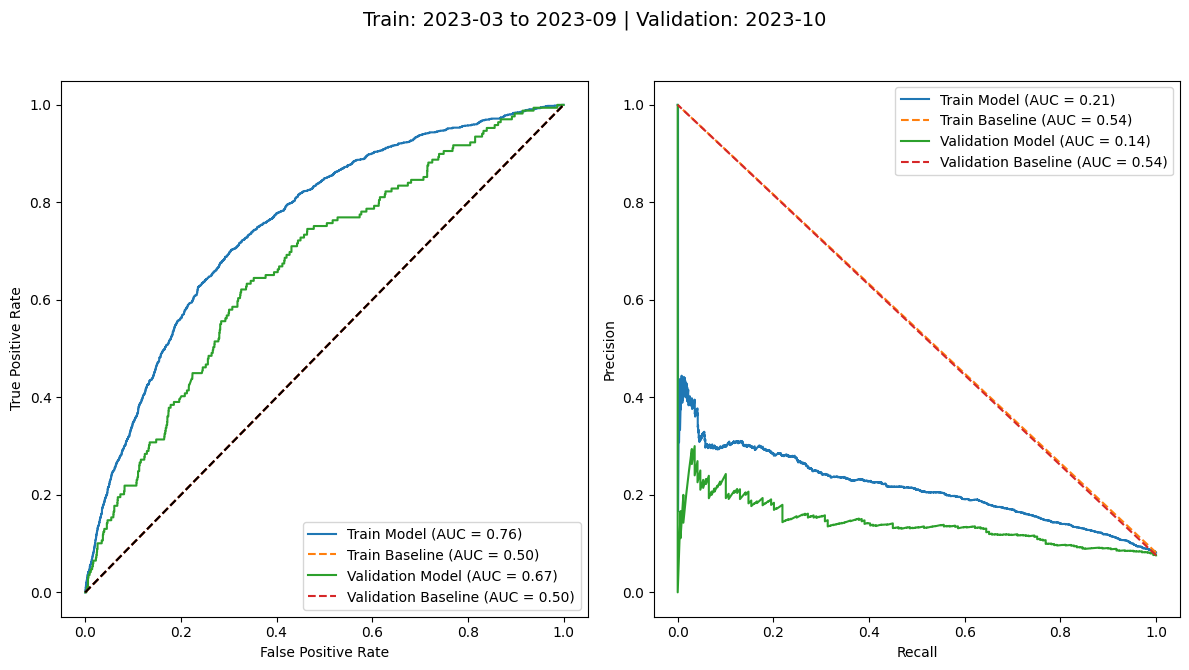

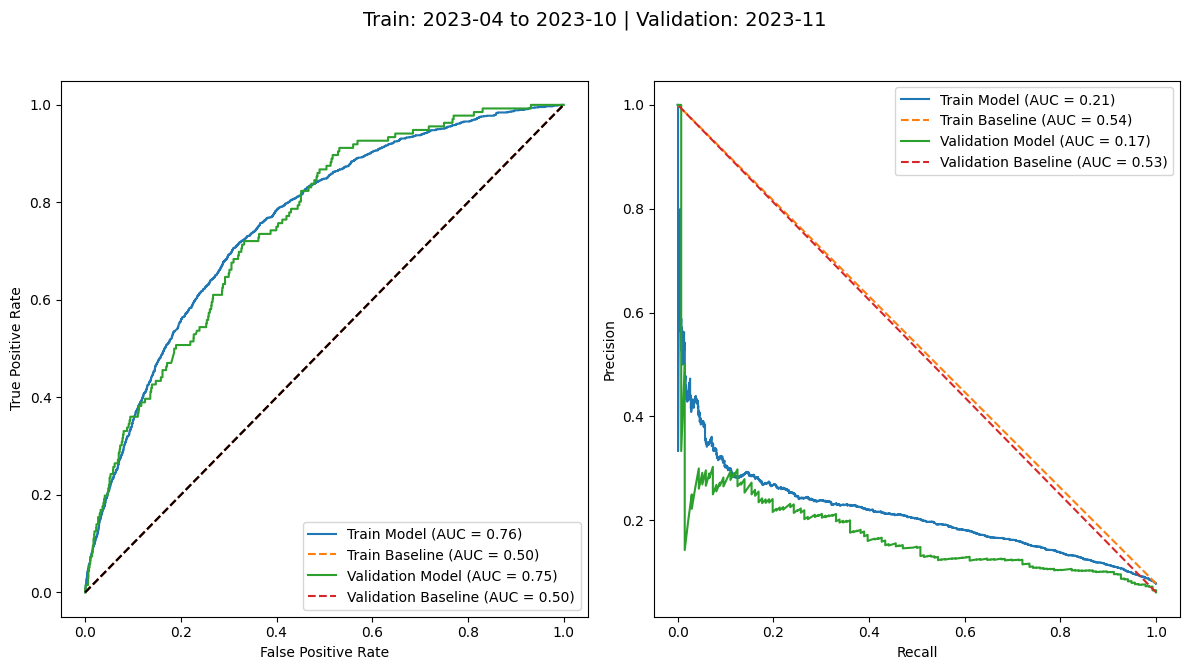

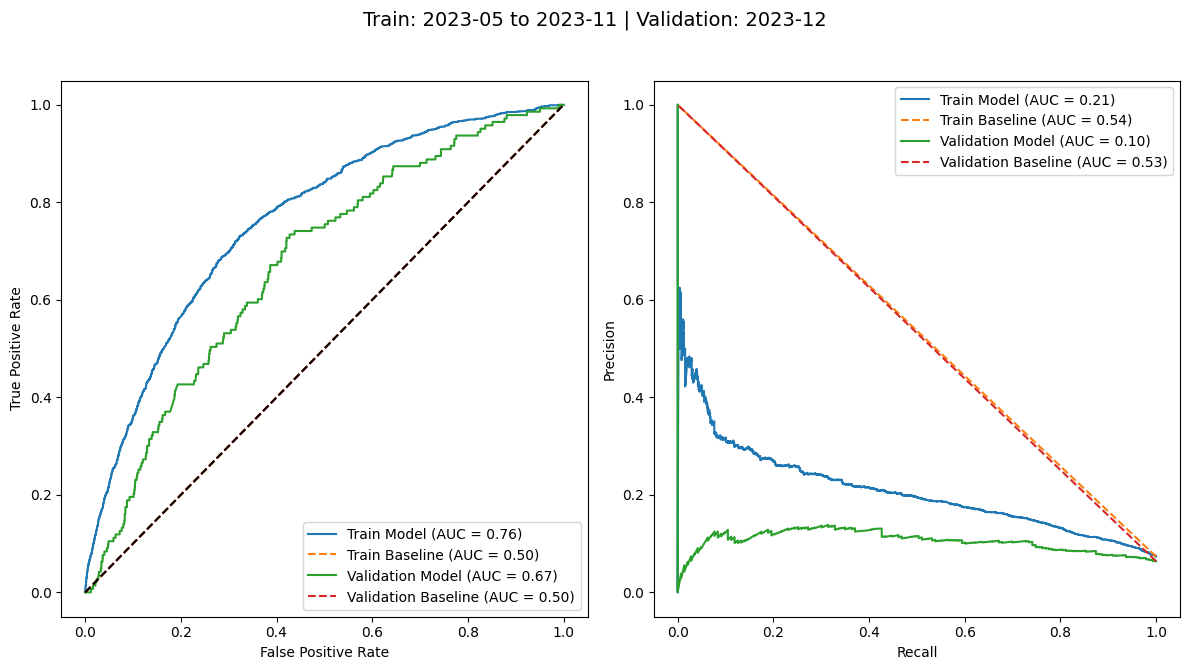

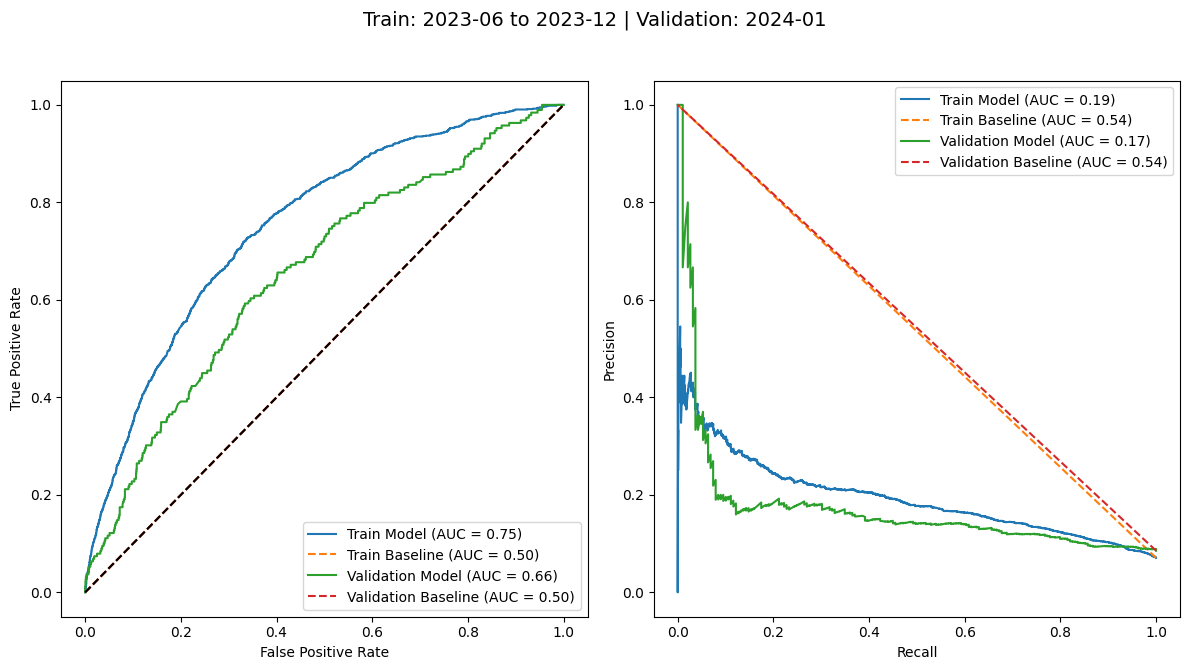

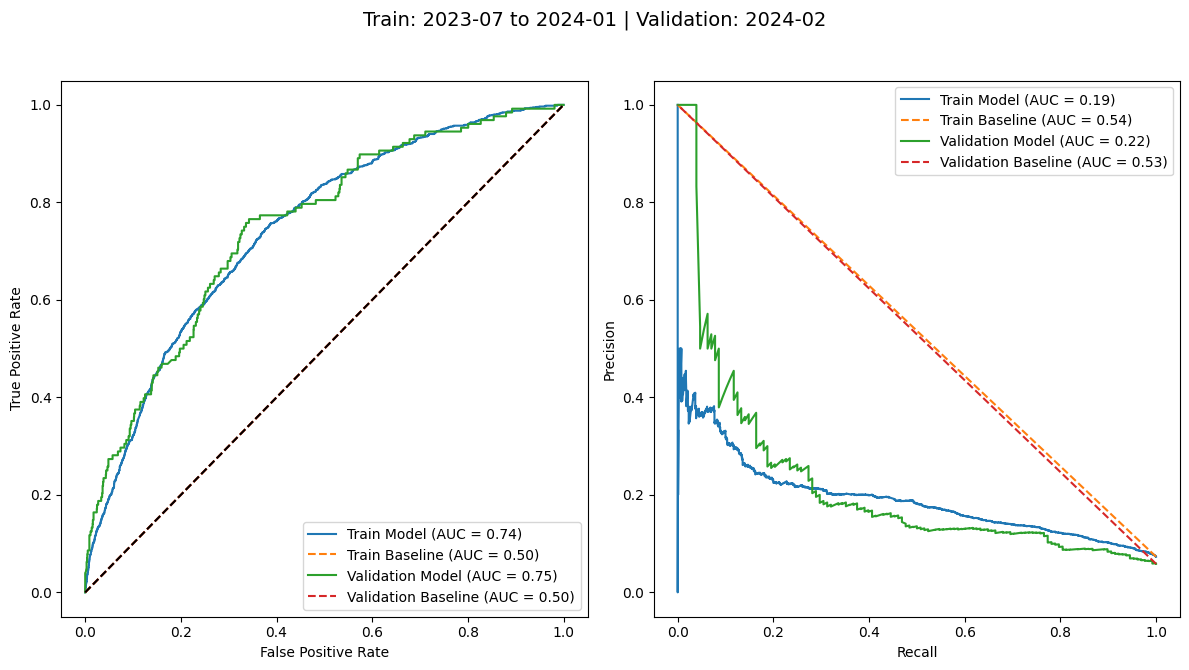

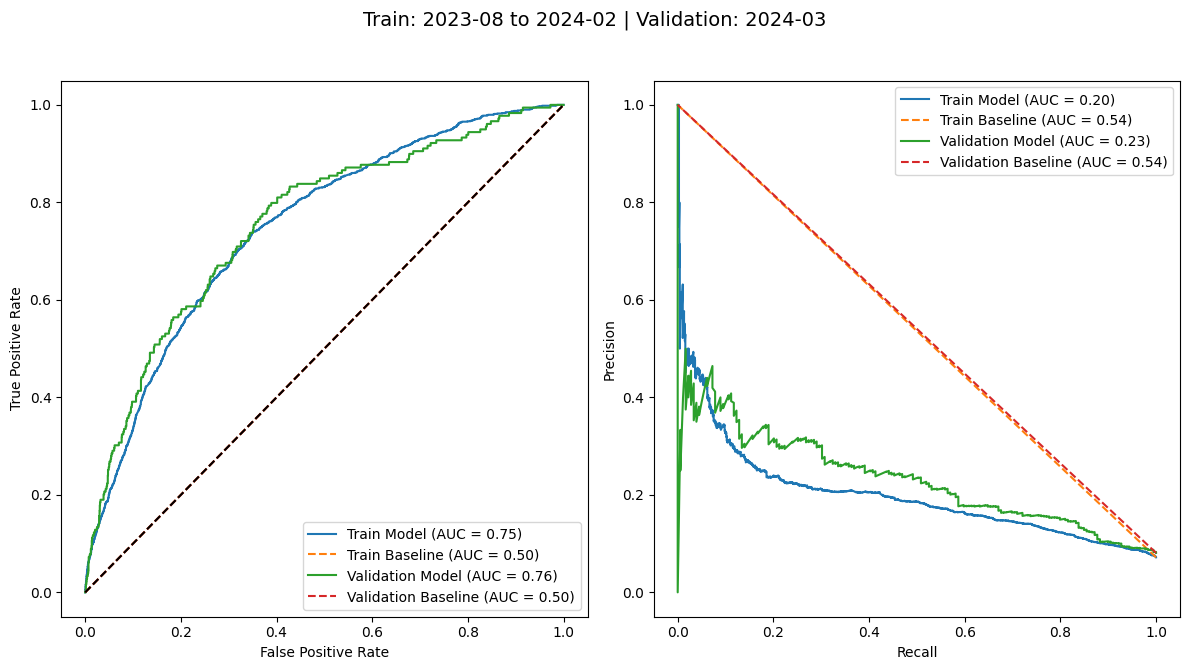

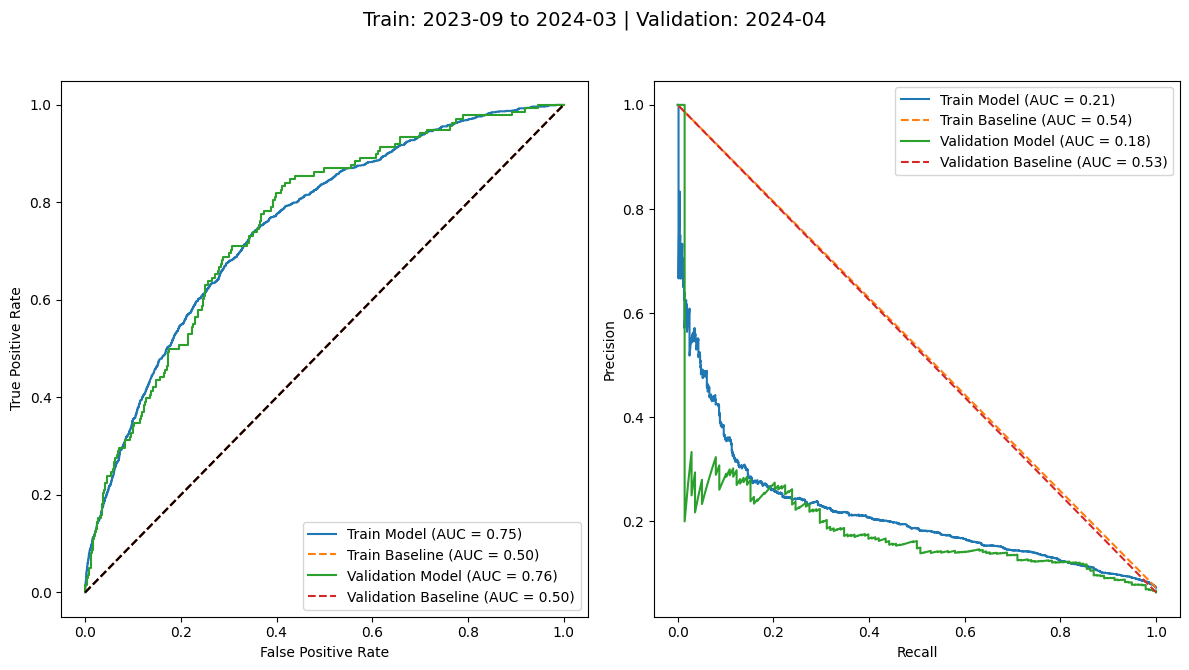

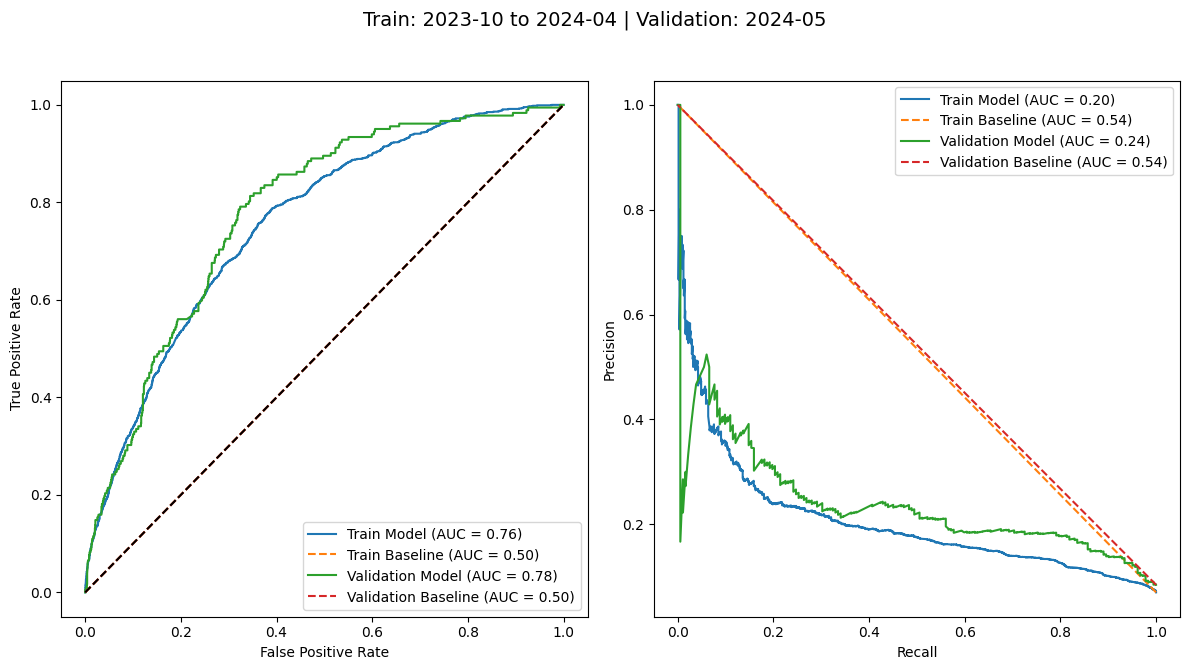

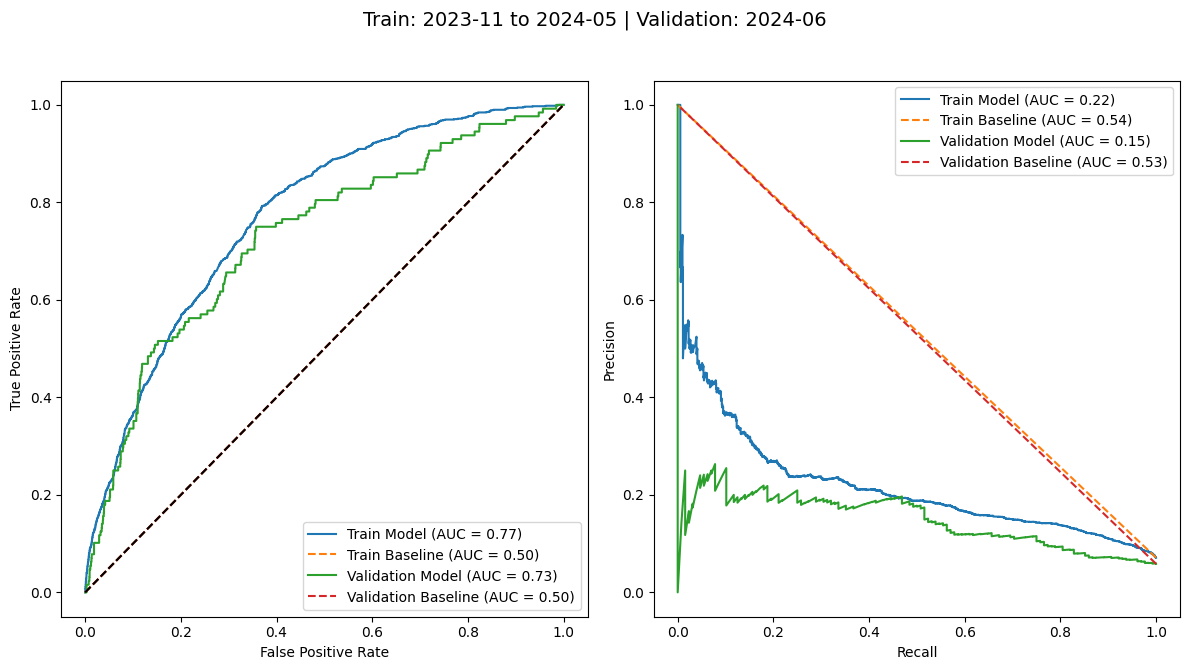

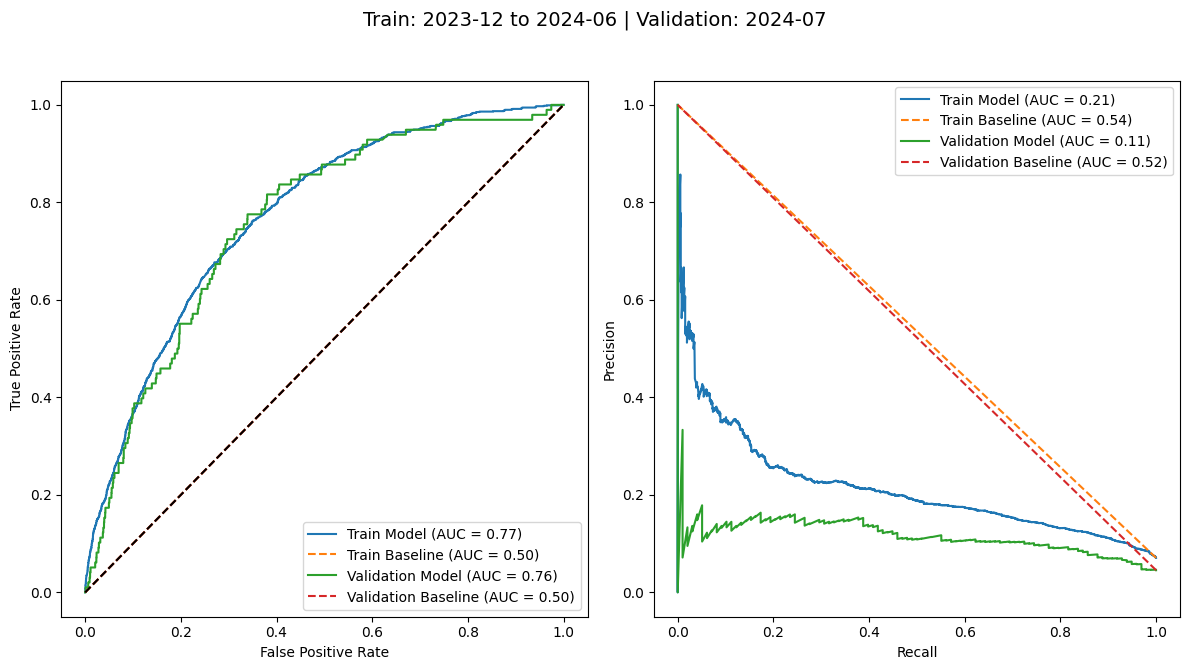

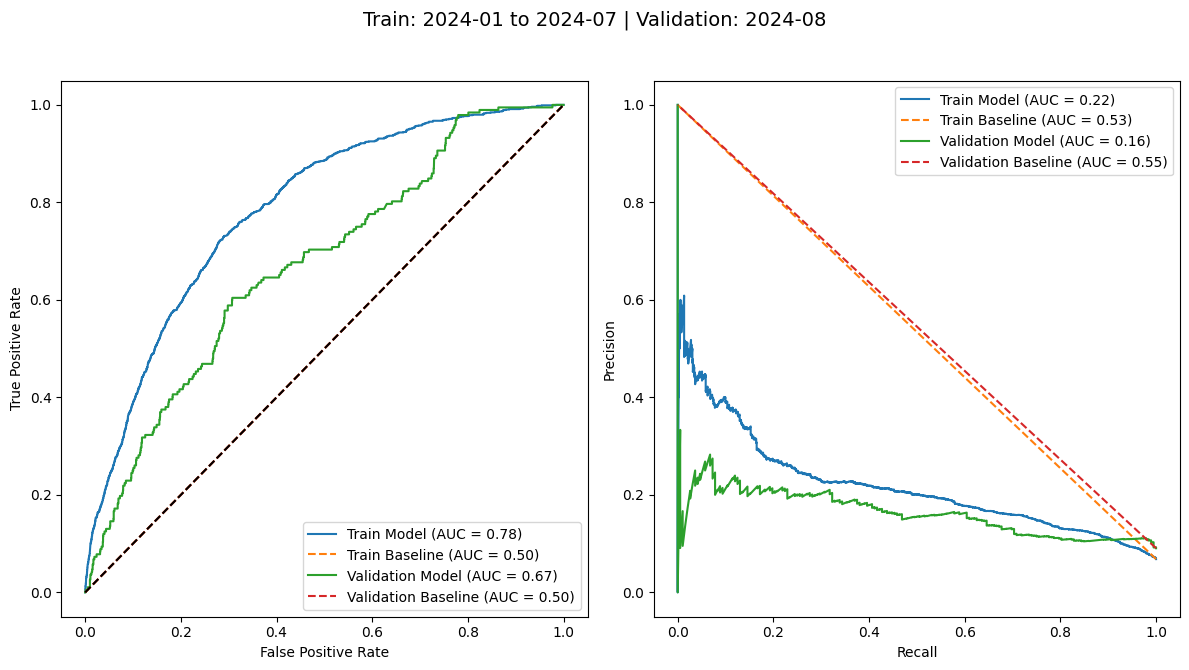

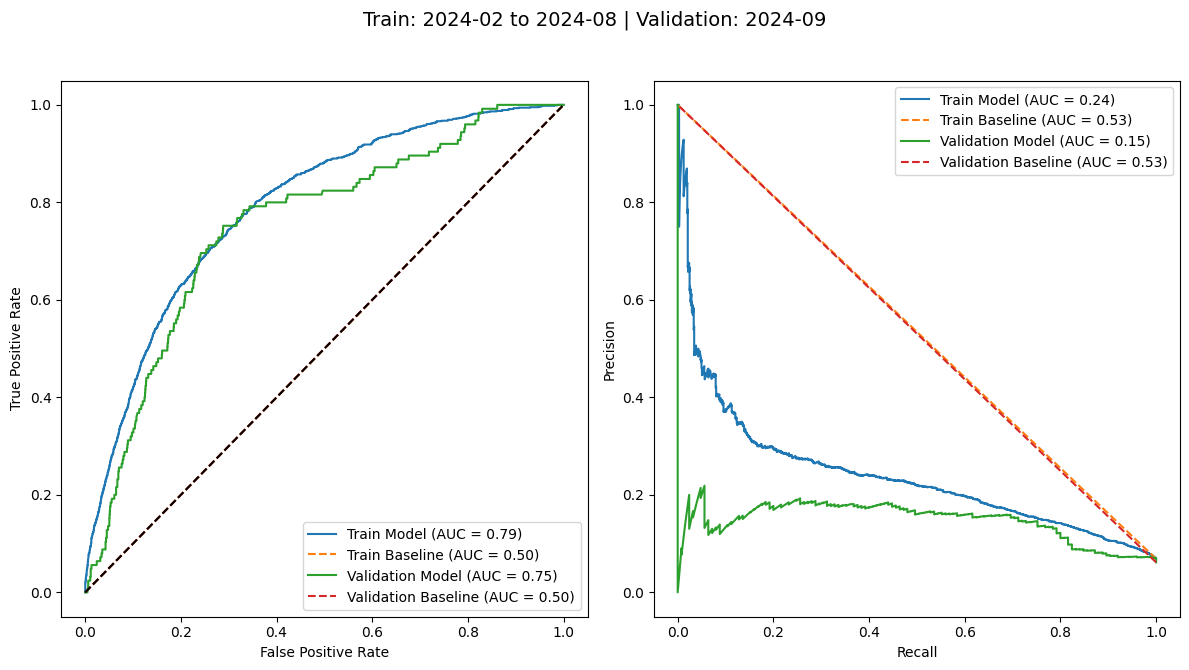

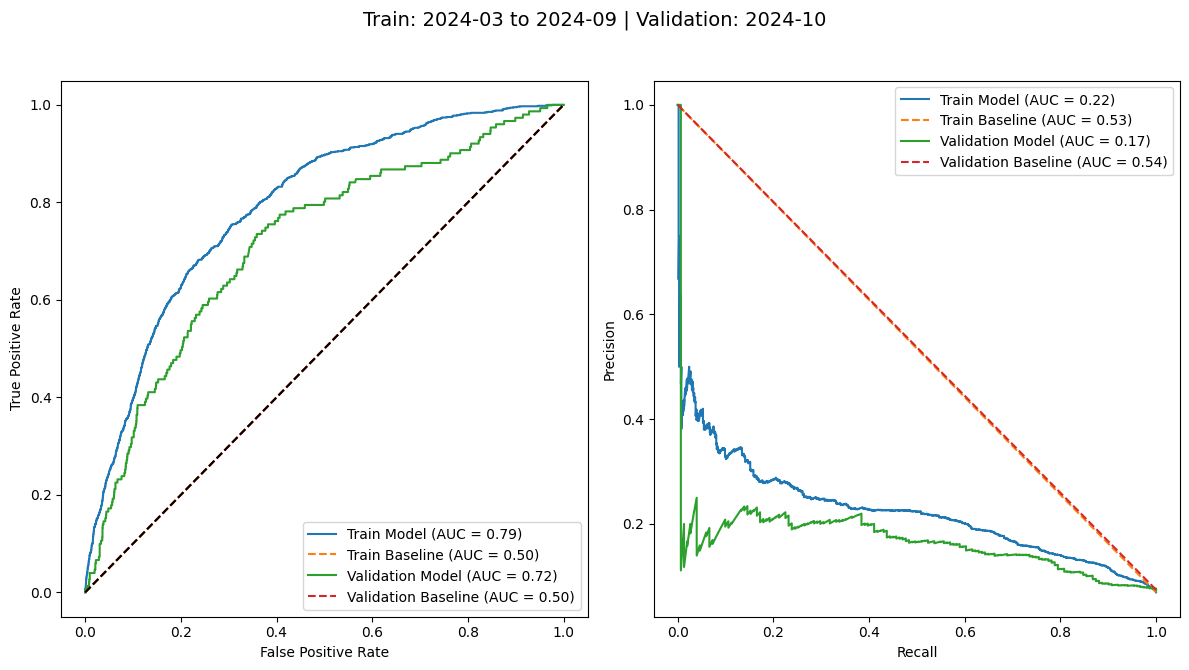

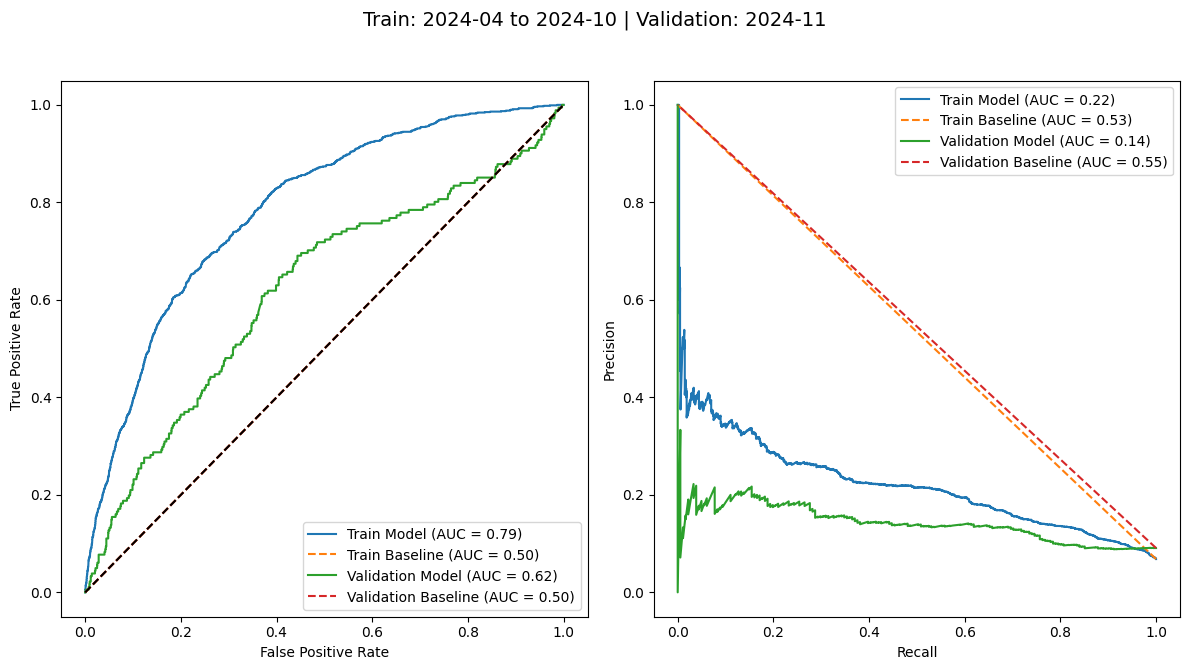

In [31]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve

all_predicted_clients = pd.concat(all_predicted_clients_list)
exec_dates = all_predicted_clients['execution_date'].unique()

# Lista para almacenar métricas de evolución
auc_metrics = []

for exec_date in exec_dates:
    date_data = all_predicted_clients[
        (all_predicted_clients['execution_date'] == exec_date) &
        (all_predicted_clients['dataset_type'].isin(['train', 'val']))
    ]
    
    if date_data.empty:
        continue
    
    train_data = date_data[date_data['dataset_type'] == 'train']
    val_data = date_data[date_data['dataset_type'] == 'val']
    
    # Obtener la media de churn del entrenamiento
    mean_churn_train = train_data['churn'].mean() if not train_data.empty else 0
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
    
    # Almacenar métricas
    roc_auc_train, pr_auc_train, roc_auc_val, pr_auc_val = np.nan, np.nan, np.nan, np.nan
    baseline_pr_auc_val = val_data['churn'].mean() if not val_data.empty else np.nan
    
    # Curva ROC
    for data, label in zip([train_data, val_data], ['Train', 'Validation']):
        if not data.empty:
            # Métricas del modelo
            fpr, tpr, _ = roc_curve(data['churn'], data['prob'])
            roc_auc = auc(fpr, tpr)
            ax1.plot(fpr, tpr, label=f'{label} Model (AUC = {roc_auc:.2f})')
            
            # Baseline (probabilidad constante = media de entrenamiento)
            baseline_prob = np.full(len(data), mean_churn_train)
            fpr_bl, tpr_bl, _ = roc_curve(data['churn'], baseline_prob)
            roc_auc_bl = auc(fpr_bl, tpr_bl)
            ax1.plot(fpr_bl, tpr_bl, linestyle='--', label=f'{label} Baseline (AUC = {roc_auc_bl:.2f})')
            
            if label == 'Train':
                roc_auc_train = roc_auc
            else:
                roc_auc_val = roc_auc
    
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()
    
    # Curva PR
    for data, label in zip([train_data, val_data], ['Train', 'Validation']):
        if not data.empty:
            # Métricas del modelo
            precision, recall, _ = precision_recall_curve(data['churn'], data['prob'])
            pr_auc = auc(recall, precision)
            ax2.plot(recall, precision, label=f'{label} Model (AUC = {pr_auc:.2f})')
            
            # Baseline (probabilidad constante = media de entrenamiento)
            baseline_prob = np.full(len(data), mean_churn_train)
            precision_bl, recall_bl, _ = precision_recall_curve(data['churn'], baseline_prob)
            pr_auc_bl = auc(recall_bl, precision_bl)
            ax2.plot(recall_bl, precision_bl, linestyle='--', label=f'{label} Baseline (AUC = {pr_auc_bl:.2f})')
            
            if label == 'Train':
                pr_auc_train = pr_auc
            else:
                pr_auc_val = pr_auc
    
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.legend()
    
    # Fechas para el título
    train_end = (exec_date + pd.DateOffset(months=6)).strftime("%Y-%m")
    val_date = (exec_date + pd.DateOffset(months=7)).strftime("%Y-%m")
    fig.suptitle(f'Train: {exec_date.strftime("%Y-%m")} to {train_end} | Validation: {val_date}', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    
    # Guardar métricas para evolución
    auc_metrics.append({
        'val_month': val_date,
        'model_train_roc_auc': roc_auc_train,
        'model_val_roc_auc': roc_auc_val,
        'baseline_roc_auc': 0.5,  # El baseline de ROC siempre es 0.5
        'model_train_pr_auc': pr_auc_train,
        'model_val_pr_auc': pr_auc_val,
        'baseline_pr_auc': baseline_pr_auc_val,  # Prevalencia en validación
    })

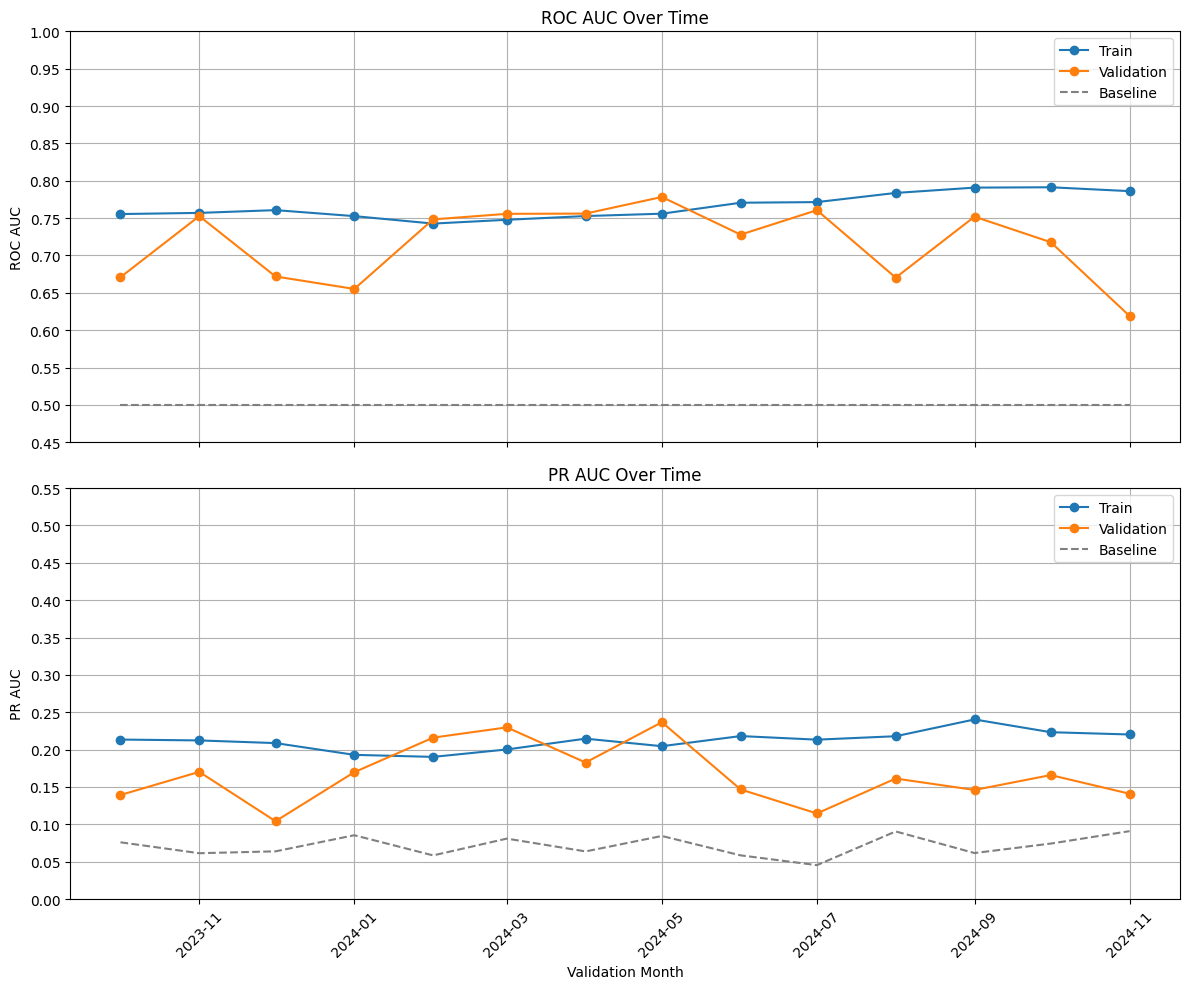

In [32]:
# Convertir a DataFrame y ordenar por fecha
auc_metrics_df = pd.DataFrame(auc_metrics)
auc_metrics_df['val_month'] = pd.to_datetime(auc_metrics_df['val_month'])
auc_metrics_df = auc_metrics_df.sort_values('val_month').reset_index(drop=True)

# Crear la figura con dos subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

# Subplot 1: ROC AUC
axs[0].plot(auc_metrics_df['val_month'], auc_metrics_df['model_train_roc_auc'], marker='o', label='Train')
axs[0].plot(auc_metrics_df['val_month'], auc_metrics_df['model_val_roc_auc'], marker='o', label='Validation')
axs[0].plot(auc_metrics_df['val_month'], auc_metrics_df['baseline_roc_auc'], linestyle='--', color='gray', label='Baseline')
axs[0].set_ylabel('ROC AUC')
axs[0].set_title('ROC AUC Over Time')
axs[0].legend()
axs[0].grid(True)

axs[0].set_ylim(0.45, 1.0)
axs[0].set_yticks(np.arange(0.45, 1.01, 0.05))

# Subplot 2: PR AUC
axs[1].plot(auc_metrics_df['val_month'], auc_metrics_df['model_train_pr_auc'], marker='o', label='Train')
axs[1].plot(auc_metrics_df['val_month'], auc_metrics_df['model_val_pr_auc'], marker='o', label='Validation')
axs[1].plot(auc_metrics_df['val_month'], auc_metrics_df['baseline_pr_auc'], linestyle='--', color='gray', label='Baseline')
axs[1].set_xlabel('Validation Month')
axs[1].set_ylabel('PR AUC')
axs[1].set_title('PR AUC Over Time')
axs[1].legend()
axs[1].grid(True)

axs[1].set_ylim(0.0, 0.55)
axs[1].set_yticks(np.arange(0.0, 0.56, 0.05))






# Ajustes finales
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Metricas de negocio

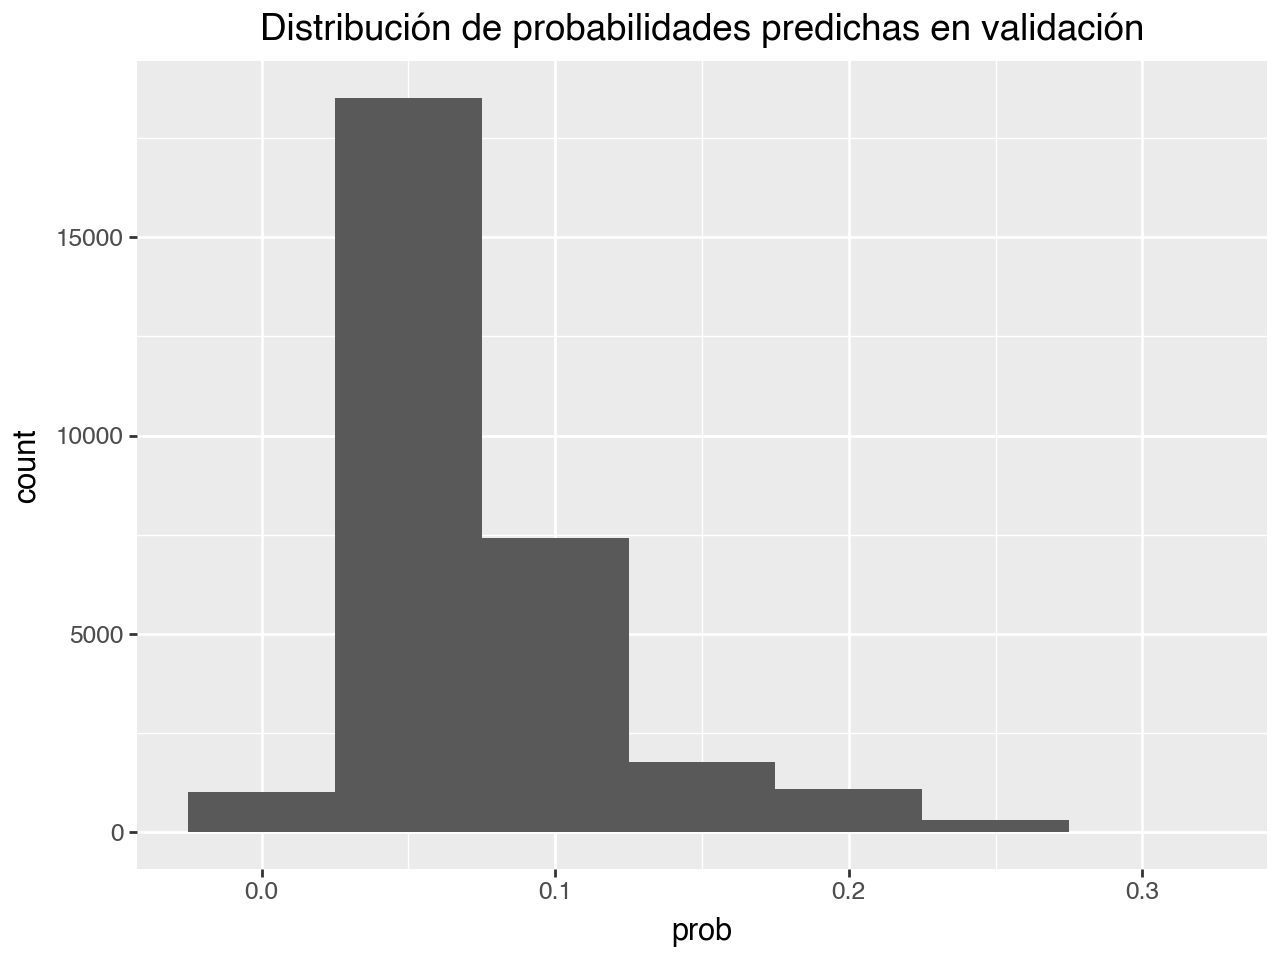

In [33]:
# Distribución de probabilidades predichas en validación
(ggplot(all_predicted_clients[all_predicted_clients['dataset_type'] == 'val'], 
        aes(x='prob')) + 
 geom_histogram(binwidth=0.05) +
 labs(title="Distribución de probabilidades predichas en validación"))



Cuando el threshold supere 0.3, todo se clasifica como 0's (son true negatives o false negatives).

Esto tendra consecuencias al plotear el ROI. De 0.3 en adelante, el modelo clasifica todo como 0's --> nadie hace churn y no tomamos ninguna accion , no hay investment por lo que no puede haber return on investment.



In [34]:
COST_FN = 1000  # coste de cliente que no detectamos y se va
COST_ACTION = 100   # coste de intervencion

In [35]:
from sklearn.metrics import confusion_matrix

def calculate_business_metrics(y_true, y_prob, cost_action, cost_fn):
    thresholds = np.linspace(0, 1, 101)
    results = []
    
    for thresh in thresholds:
        y_pred = (y_prob >= thresh).astype(int)
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        cost = (fp +tp)* cost_action
        saved = tp * cost_fn
        net_profit = saved - cost
        roi = (net_profit / cost) * 100 if cost > 0 else np.nan
        
        results.append({
            'threshold': thresh,
            'net_profit': net_profit,
            'roi': roi,
            'fp': fp,
            'tp': tp
        })
    
    return pd.DataFrame(results)

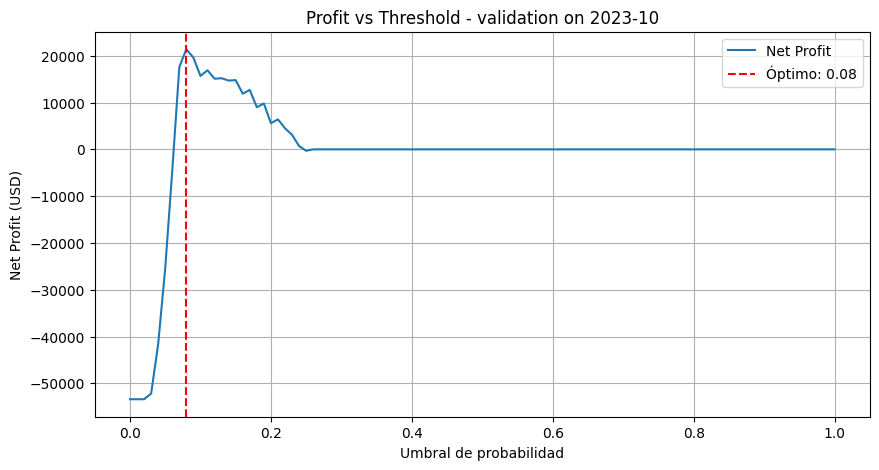

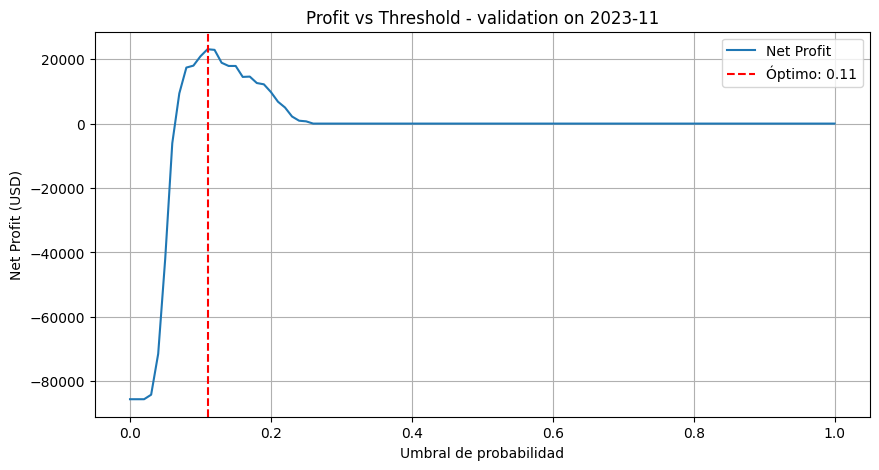

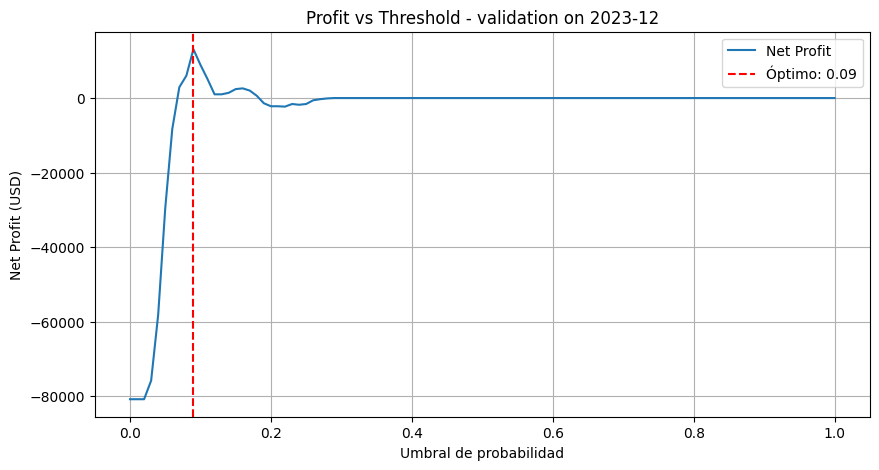

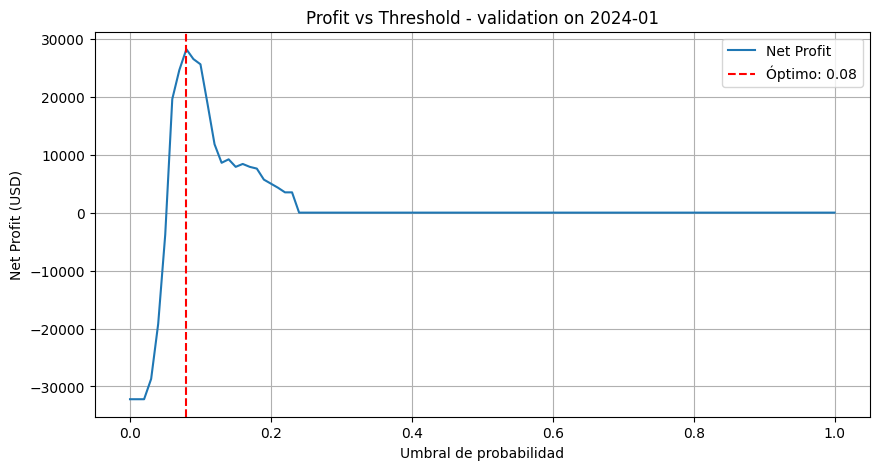

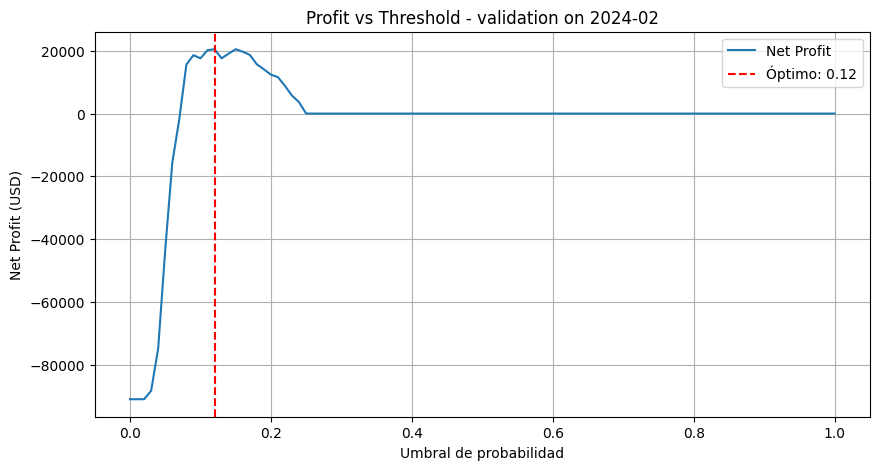

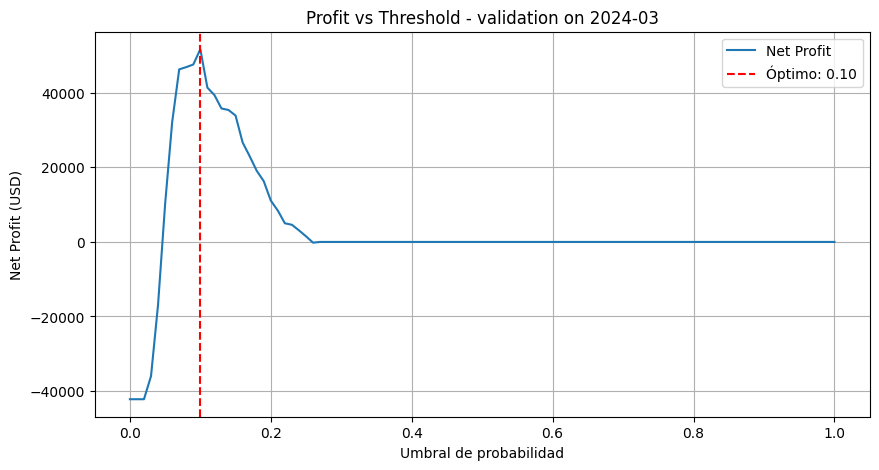

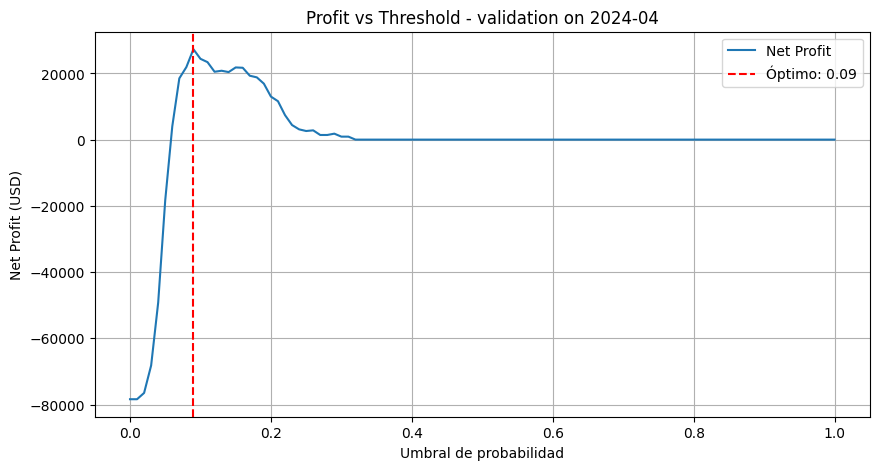

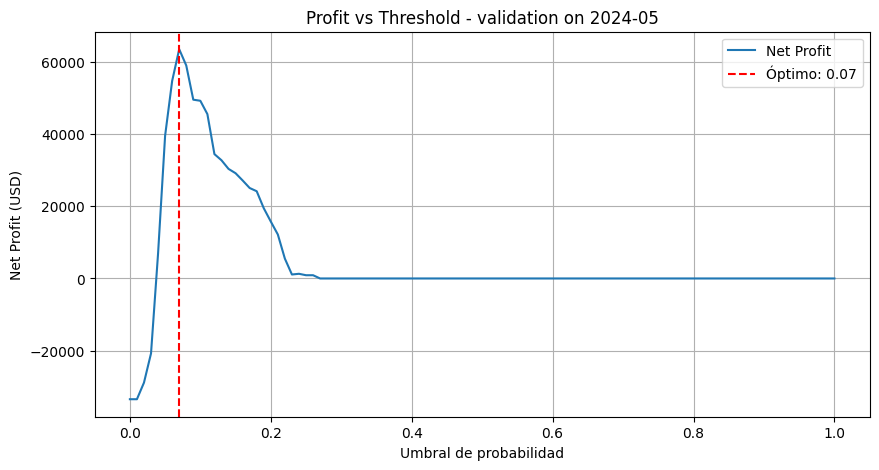

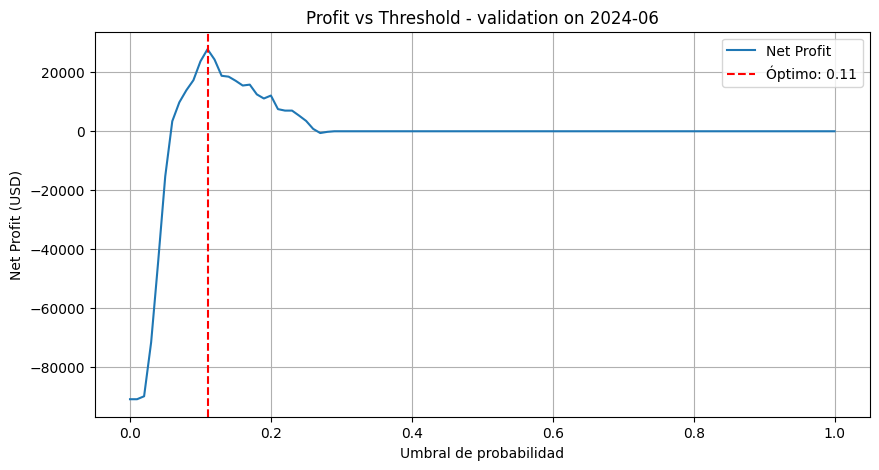

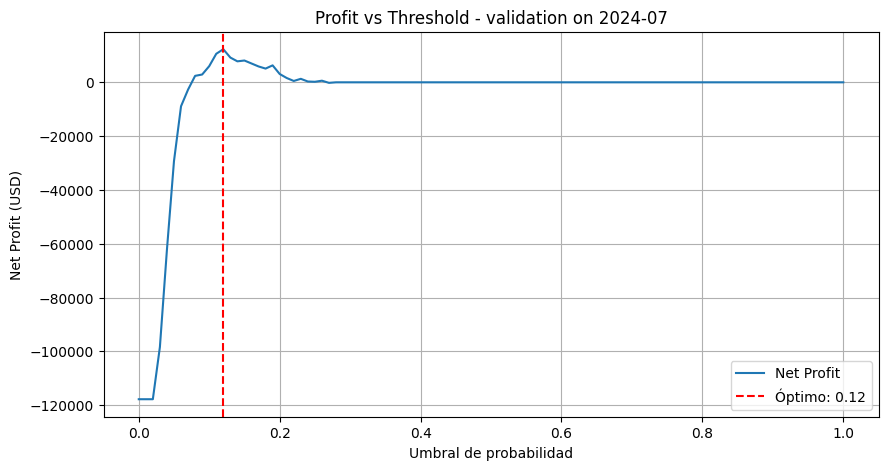

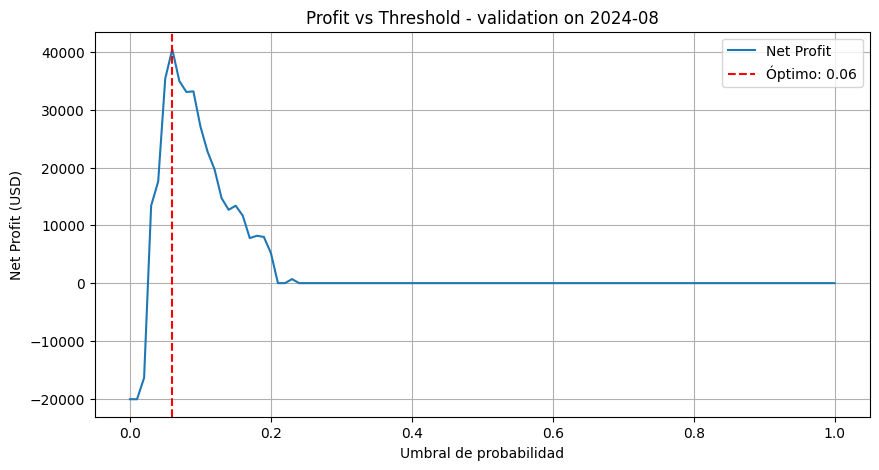

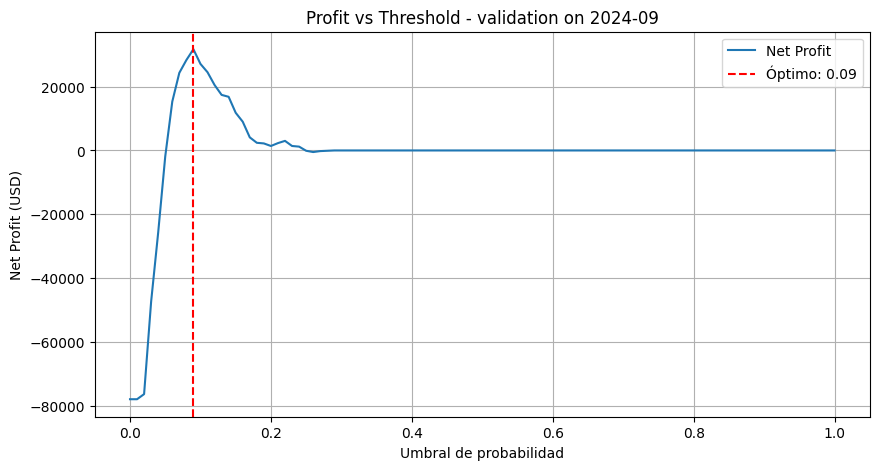

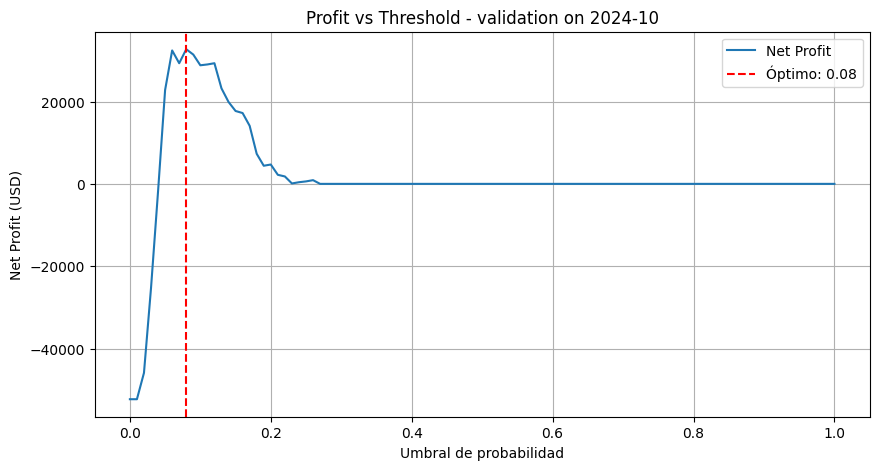

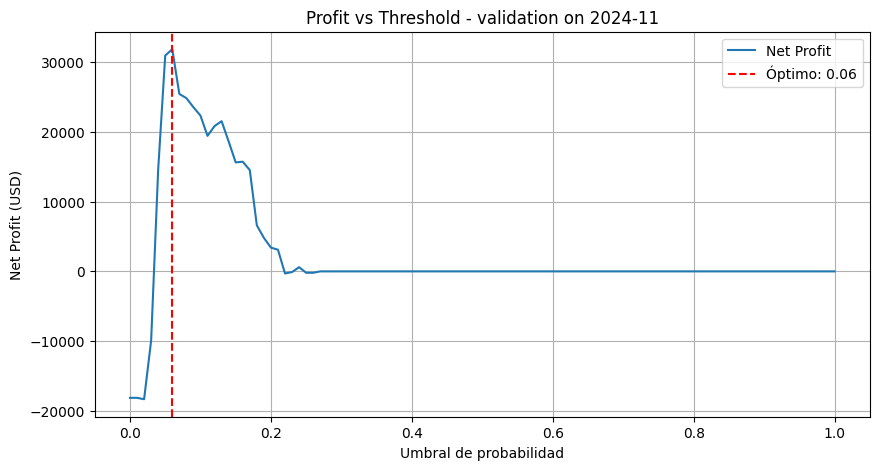

In [36]:
business_metrics_list = []

for exec_date in exec_dates:
    val_data = all_predicted_clients[
        (all_predicted_clients['execution_date'] == exec_date) &
        (all_predicted_clients['dataset_type'] == 'val')
    ]
    
    if val_data.empty:
        continue
    
    # Calcular métricas
    metrics_df = calculate_business_metrics(val_data['churn'], val_data['prob'], COST_ACTION, COST_FN)
    
    # Encontrar punto óptimo
    optimal_idx = metrics_df['net_profit'].idxmax()
    optimal_row = metrics_df.loc[optimal_idx]
    
    # Guardar métricas
    business_metrics_list.append({
        'execution_date': exec_date,
        'optimal_threshold': optimal_row['threshold'],
        'max_net_profit': optimal_row['net_profit'],
        'roi_at_optimal': optimal_row['roi'],
        'fp_at_optimal': optimal_row['fp'],
        'tp_at_optimal': optimal_row['tp']
    })
    
    # Plot curva de profit
    plt.figure(figsize=(10, 5))
    plt.plot(metrics_df['threshold'], metrics_df['net_profit'], label='Net Profit')
    plt.axvline(optimal_row['threshold'], color='r', linestyle='--', label=f'Óptimo: {optimal_row["threshold"]:.2f}')
    plt.title(f'Profit vs Threshold - validation on {(exec_date + relativedelta(months=7)).strftime("%Y-%m")}')
    plt.xlabel('Umbral de probabilidad')
    plt.ylabel('Net Profit (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()

business_metrics_df = pd.DataFrame(business_metrics_list)

Entre 0.08 y 0.11 aprox funciona bien en todos los periodos, habria que encontrar el que maximice

Estas graficas calculan el profit por mes en funcion del threshold. A partir de 0.25 aprox, el modelo clasifica todo como 0's, intuye que nacie hace churn y no actua , lo cual no requiere investment. Esto se ve a continuacion en las graficas ROI, al no haber investment no puede haber return on investment.

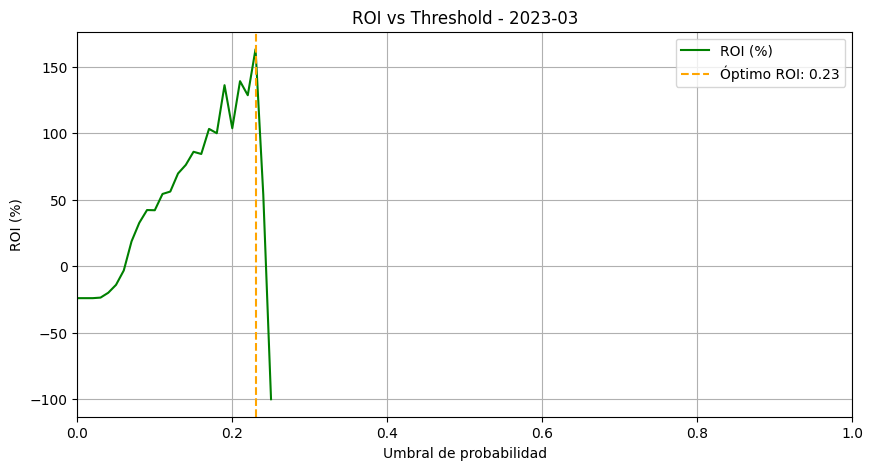

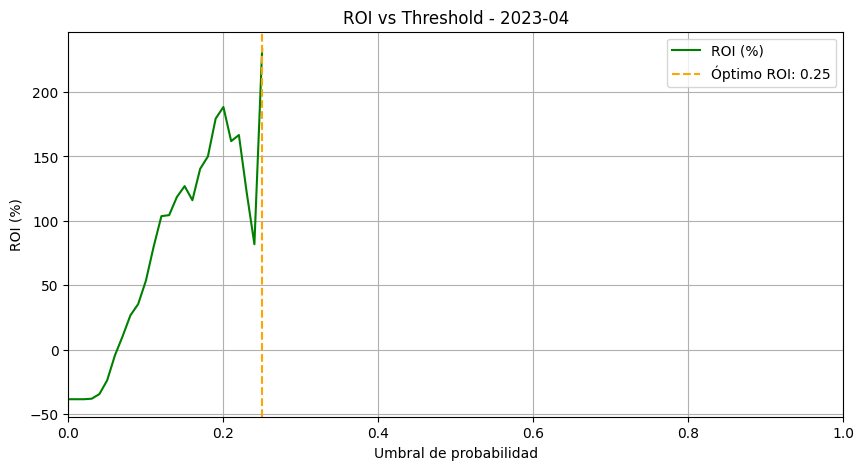

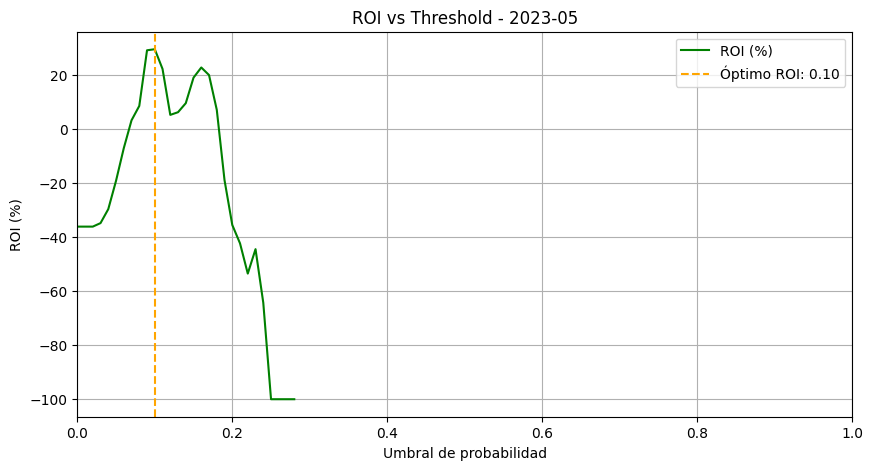

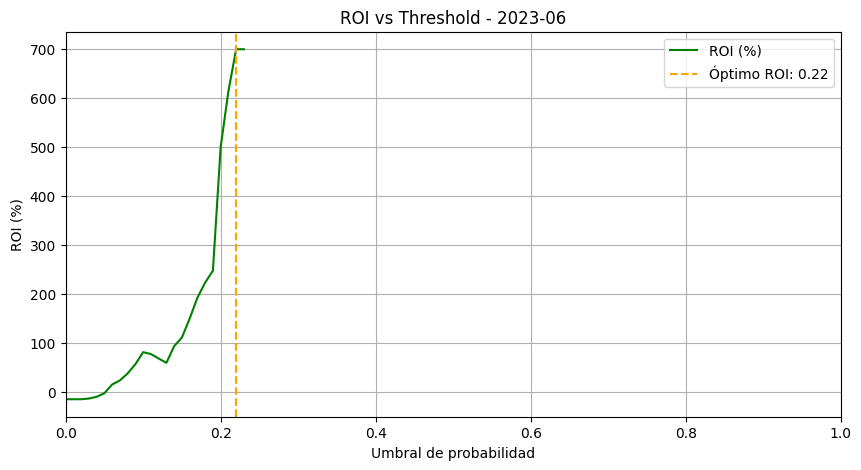

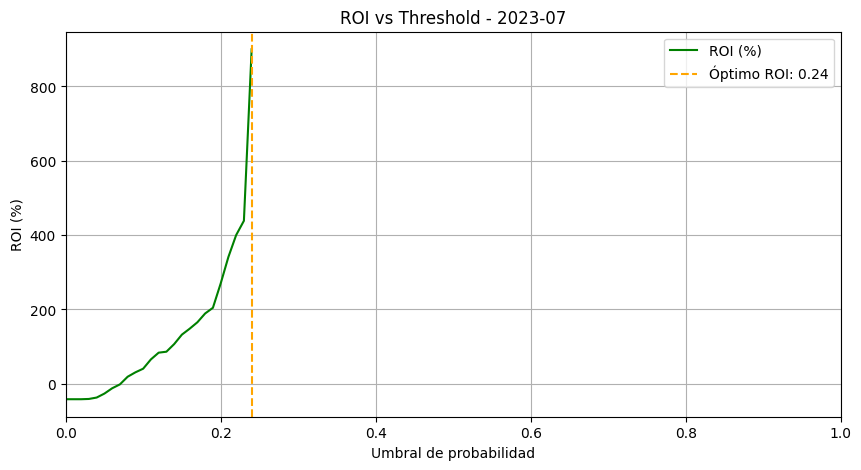

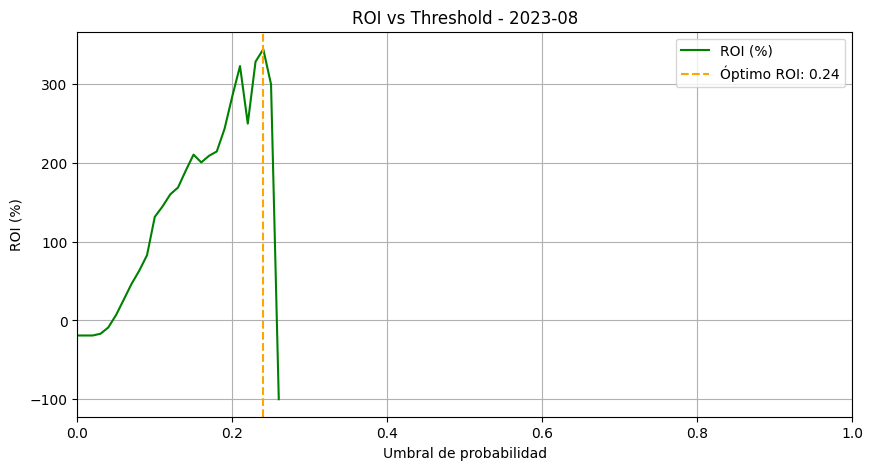

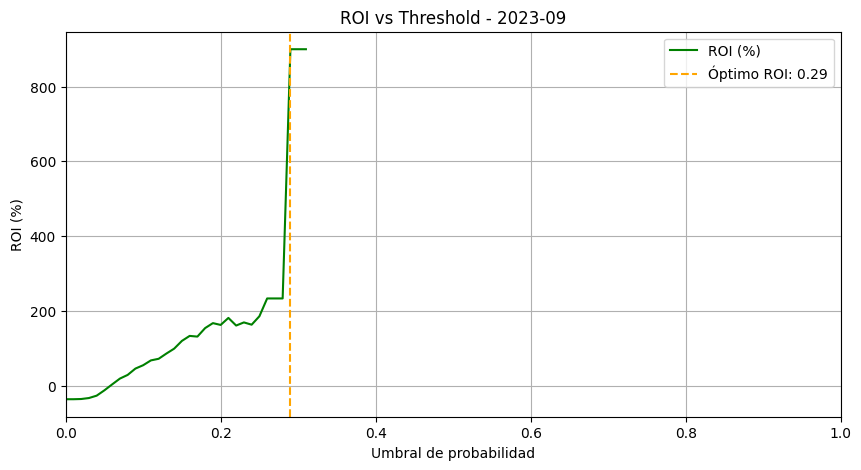

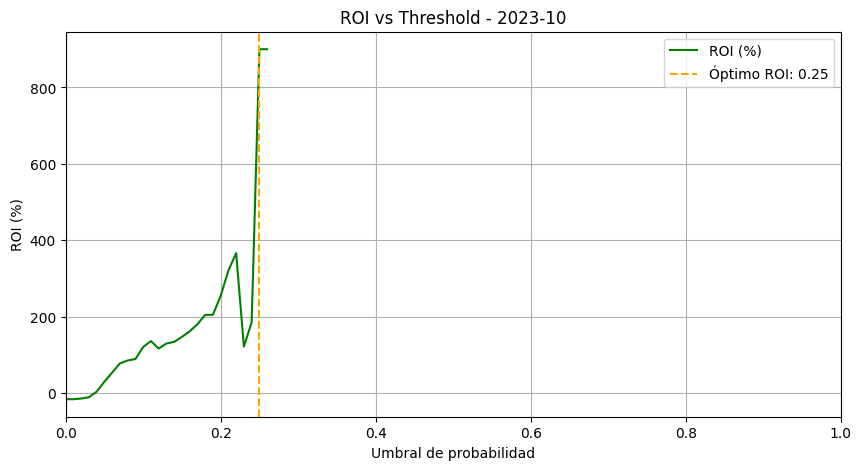

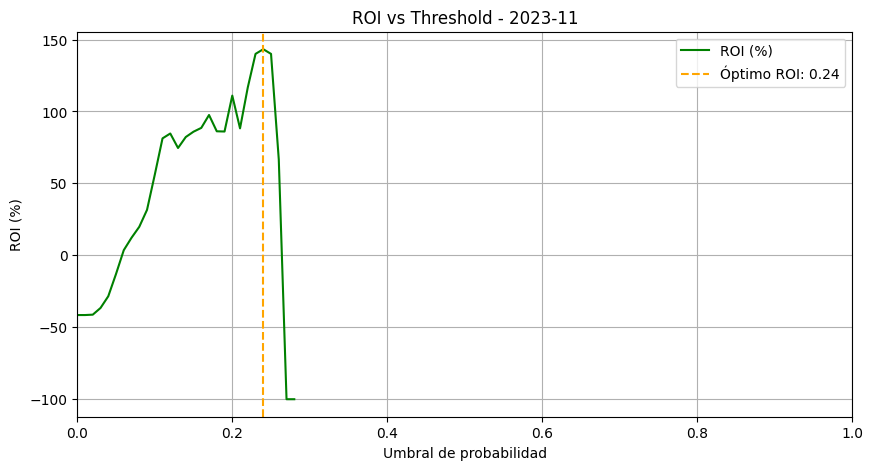

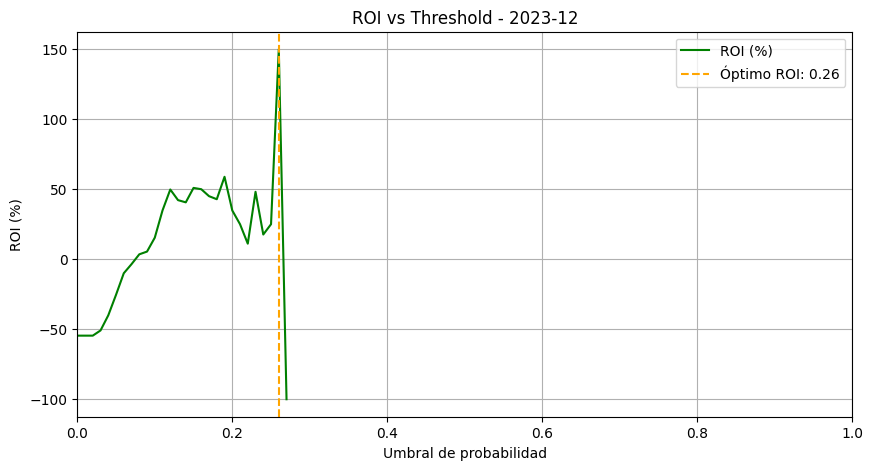

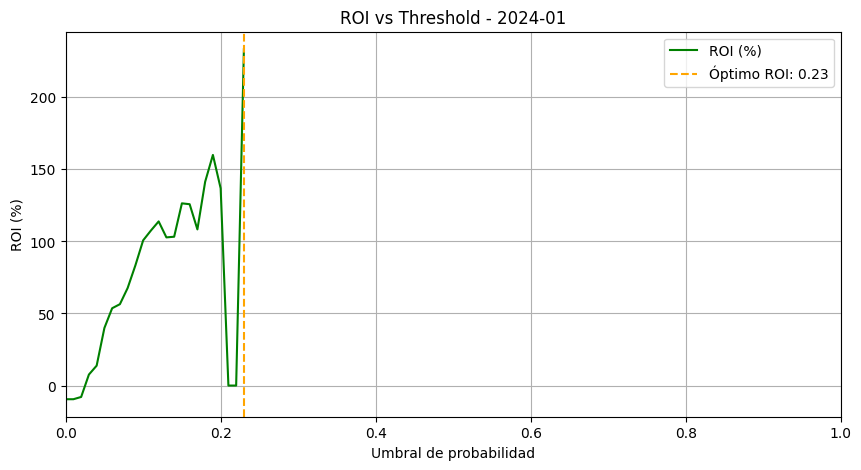

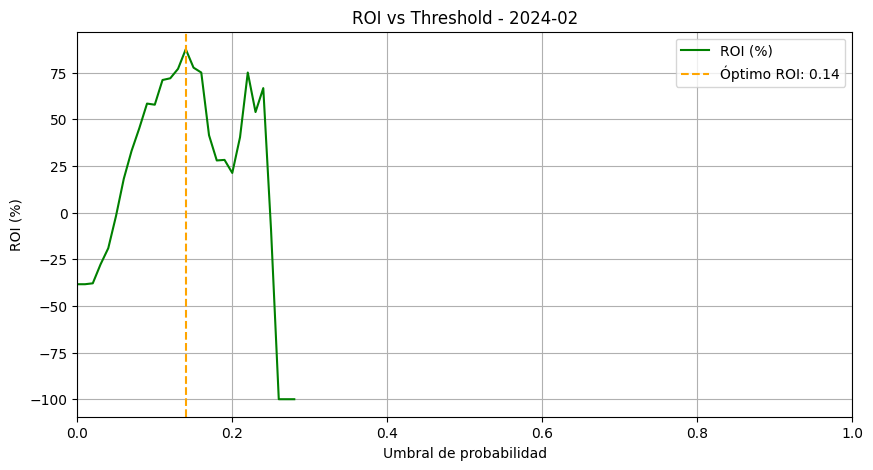

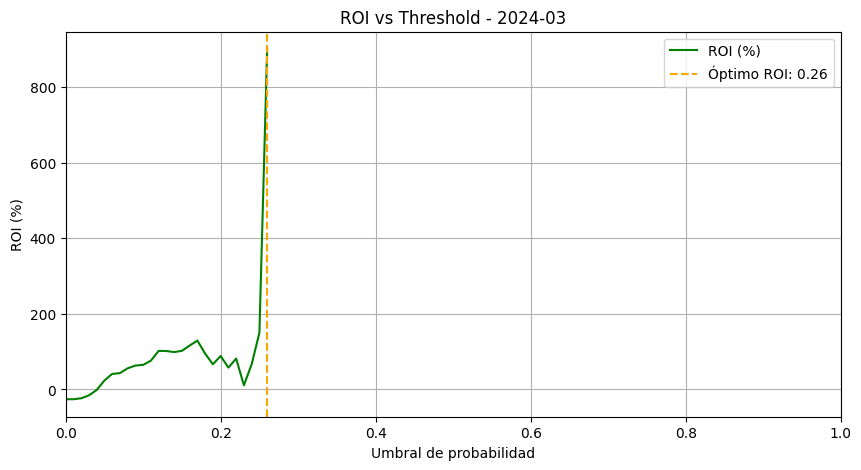

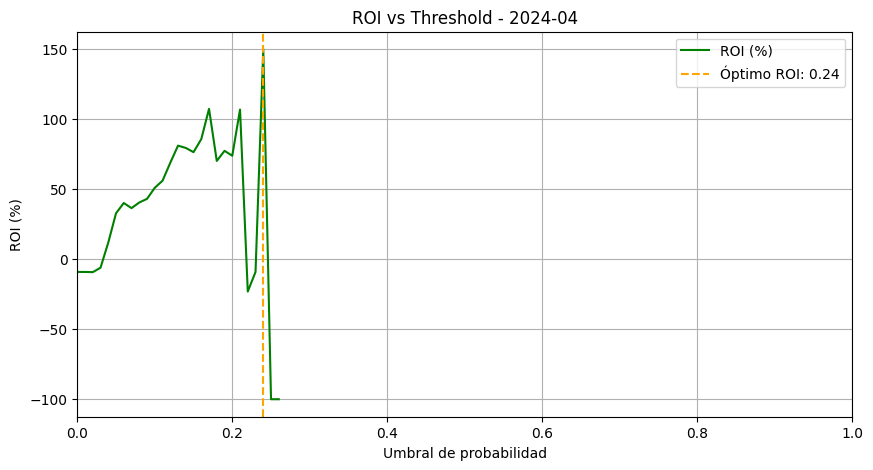

In [37]:
business_metrics_list = []

for exec_date in exec_dates:
    val_data = all_predicted_clients[
        (all_predicted_clients['execution_date'] == exec_date) &
        (all_predicted_clients['dataset_type'] == 'val')
    ]
    
    if val_data.empty:
        continue
    
    # Calcular métricas
    metrics_df = calculate_business_metrics(val_data['churn'], val_data['prob'], COST_ACTION, COST_FN)
    
    # Encontrar punto óptimo según ROI
    optimal_roi_idx = metrics_df['roi'].idxmax()
    optimal_roi_row = metrics_df.loc[optimal_roi_idx]

    # Plot curva de ROI
    plt.figure(figsize=(10, 5))
    plt.plot(metrics_df['threshold'], metrics_df['roi'], label='ROI (%)', color='green')
    plt.axvline(optimal_roi_row['threshold'], color='orange', linestyle='--', label=f'Óptimo ROI: {optimal_roi_row["threshold"]:.2f}')
    plt.title(f'ROI vs Threshold - {exec_date.strftime("%Y-%m")}')
    plt.xlabel('Umbral de probabilidad')
    plt.ylabel('ROI (%)')
    plt.xlim(0, 1)  # <- Forzar eje x entre 0 y 1
    plt.legend()
    plt.grid(True)
    plt.show()

En cuanto al ROI, si buscamos el optimo en cada mes varia mucho, porque encuentra la "mejor apuesta", maximizar las ganancias con la minima inversion y es mas trivial.

## To do

- Entender bien el ROI y como encontrar un threshold que generalice para todos los periodos

- Buscar otro metodo alternativo al ROI optimo actual ya que actualmente un threshold optimo en un mes es muy malo en el siguiente. En vez de buscar el ROI mas alto, hay que buscar el ROI mas estable ( que a la derecha y a la izquierda no haya picos ?)